<a href="https://colab.research.google.com/github/kermityan/EPAM-DS-ML-Course-Notebooks/blob/main/Bikes_Rental_Forecasting_(Time_Series).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install git+https://github.com/statsmodels/statsmodels

In [ ]:
! pip install plotly

In [ ]:
! pip install markupsafe==2.0.1

In [ ]:
!pip install statsmodels

In [ ]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import scipy.stats as st
import warnings
from datetime import timedelta
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf

Reading dataset from Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
FILE_PATH = "/content/drive/MyDrive/ds_data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filename = 'hour.csv'
df_full = pd.read_csv(os.path.join(FILE_PATH, filename))

df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [ ]:
df_full.head(24)

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0         1  2011-01-01       1   0     1   0        0        6           0   
1         2  2011-01-01       1   0     1   1        0        6           0   
2         3  2011-01-01       1   0     1   2        0        6           0   
3         4  2011-01-01       1   0     1   3        0        6           0   
4         5  2011-01-01       1   0     1   4        0        6           0   
5         6  2011-01-01       1   0     1   5        0        6           0   
6         7  2011-01-01       1   0     1   6        0        6           0   
7         8  2011-01-01       1   0     1   7        0        6           0   
8         9  2011-01-01       1   0     1   8        0        6           0   
9        10  2011-01-01       1   0     1   9        0        6           0   
10       11  2011-01-01       1   0     1  10        0        6           0   
11       12  2011-01-01       1   0     1  11        0        6           0   
12       13  2011-01-01       1   0     1  12        0        6           0   
13       14  2011-01-01       1   0     1  13        0        6           0   
14       15  2011-01-01       1   0     1  14        0        6           0   
15       16  2011-01-01       1   0     1  15        0        6           0   
16       17  2011-01-01       1   0     1  16        0        6           0   
17       18  2011-01-01       1   0     1  17        0        6           0   
18       19  2011-01-01       1   0     1  18        0        6           0   
19       20  2011-01-01       1   0     1  19        0        6           0   
20       21  2011-01-01       1   0     1  20        0        6           0   
21       22  2011-01-01       1   0     1  21        0        6           0   
22       23  2011-01-01       1   0     1  22        0        6           0   
23       24  2011-01-01       1   0     1  23        0        6           0   

    weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0            1  0.24  0.2879  0.81     0.0000       3          13   16  
1            1  0.22  0.2727  0.80     0.0000       8          32   40  
2            1  0.22  0.2727  0.80     0.0000       5          27   32  
3            1  0.24  0.2879  0.75     0.0000       3          10   13  
4            1  0.24  0.2879  0.75     0.0000       0           1    1  
5            2  0.24  0.2576  0.75     0.0896       0           1    1  
6            1  0.22  0.2727  0.80     0.0000       2           0    2  
7            1  0.20  0.2576  0.86     0.0000       1           2    3  
8            1  0.24  0.2879  0.75     0.0000       1           7    8  
9            1  0.32  0.3485  0.76     0.0000       8           6   14  
10           1  0.38  0.3939  0.76     0.2537      12          24   36  
11           1  0.36  0.3333  0.81     0.2836      26          30   56  
12           1  0.42  0.4242  0.77     0.2836      29          55   84  
13           2  0.46  0.4545  0.72     0.2985      47          47   94  
14           2  0.46  0.4545  0.72     0.2836      35          71  106  
15           2  0.44  0.4394  0.77     0.2985      40          70  110  
16           2  0.42  0.4242  0.82     0.2985      41          52   93  
17           2  0.44  0.4394  0.82     0.2836      15          52   67  
18           3  0.42  0.4242  0.88     0.2537       9          26   35  
19           3  0.42  0.4242  0.88     0.2537       6          31   37  
20           2  0.40  0.4091  0.87     0.2537      11          25   36  
21           2  0.40  0.4091  0.87     0.1940       3          31   34  
22           2  0.40  0.4091  0.94     0.2239      11          17   28  
23           2  0.46  0.4545  0.88     0.2985      15          24   39

In [ ]:
plt.rcParams["figure.figsize"] = (18, 8)
SEED = 844
TARGET = 'cnt'


Dataset fields description:

	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit :
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

EDA for this dataset was conducted during previous homework fulfillment: https://colab.research.google.com/drive/1wlTG2-9qCFnG6ooZZm1h5dsV_LPbIYYV?usp=sharing

Creating a few copies of the dataframe containing only date-time and the target:

In [ ]:
df = df_full[['dteday', 'hr', TARGET]]
df.rename(columns={"dteday": "date"}, inplace=True)
df_full.rename(columns={"dteday": "date"}, inplace=True)

In [ ]:
df['date'] = pd.to_datetime(df.date.astype(str) + ' ' +df.hr.astype(str)+':00:00')
df_full['date'] = pd.to_datetime(df_full.date.astype(str) + ' ' +df_full.hr.astype(str)+':00:00')

In [ ]:
df = df.set_index(pd.DatetimeIndex(df['date']))

In [ ]:
df = df.drop(['date','hr'], axis=1)

In [ ]:
df

cnt
date                    
2011-01-01 00:00:00   16
2011-01-01 01:00:00   40
2011-01-01 02:00:00   32
2011-01-01 03:00:00   13
2011-01-01 04:00:00    1
...                  ...
2012-12-31 19:00:00  119
2012-12-31 20:00:00   89
2012-12-31 21:00:00   90
2012-12-31 22:00:00   61
2012-12-31 23:00:00   49

[17379 rows x 1 columns]

Min and max dates in the dataset:

In [ ]:
start_date = df.index.min()
end_date = df.index.max()
print(start_date, end_date)

2011-01-01 00:00:00 2012-12-31 23:00:00


Calculating rolling (montly) mean and rolling standard deviation:

In [ ]:
rolling_mean = df.rolling(24*30).mean()
rolling_std = df.rolling(24*30).std()
rolling_mean

cnt
date                           
2011-01-01 00:00:00         NaN
2011-01-01 01:00:00         NaN
2011-01-01 02:00:00         NaN
2011-01-01 03:00:00         NaN
2011-01-01 04:00:00         NaN
...                         ...
2012-12-31 19:00:00  165.844444
2012-12-31 20:00:00  165.555556
2012-12-31 21:00:00  165.334722
2012-12-31 22:00:00  165.144444
2012-12-31 23:00:00  164.993056

[17379 rows x 1 columns]

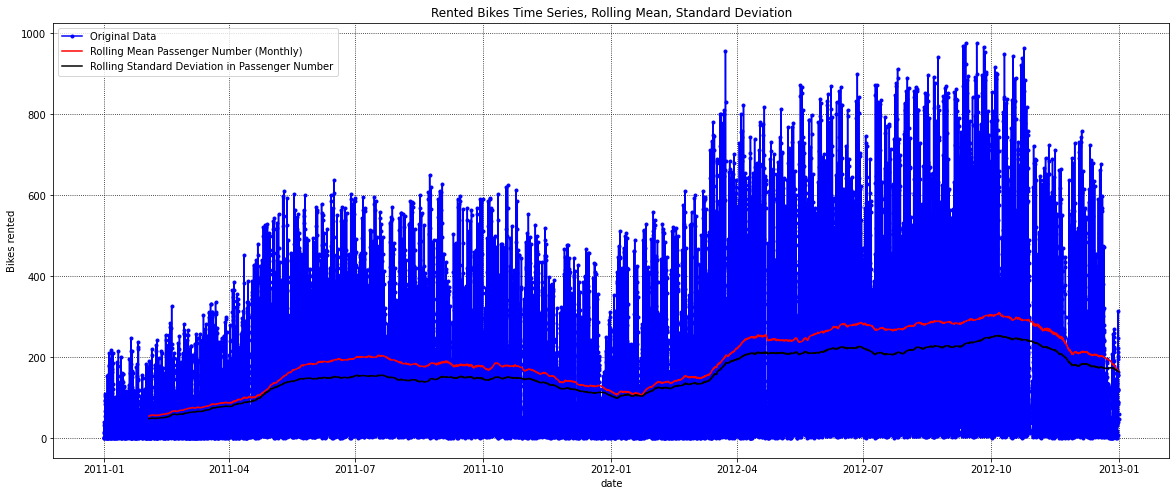

In [ ]:
plt.subplots(1, 1, figsize=(20, 8))
plt.plot(df, '-ro', markersize=3, color="blue",label="Original Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean Passenger Number (Monthly)")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in Passenger Number")
plt.grid(linestyle=':', color='k')
plt.xlabel("date")
plt.ylabel("Bikes rented")
plt.title("Rented Bikes Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")
plt.show()

As we can see mean and standard deviation change through time so we probably have a non-stationary process here. We can also see a distinct yearly pattern in the data - we have a rising trend in the first half of the year and a declining - in the second half. It is also obvious that there is an uptrend in the data - the second year has on average higher value of the target variable.

I am going to study the zoomed-in version of the time series to check if there are some more patterns:

In [ ]:
month_start = '2011-01-01 00:00:00'
month_end = '2011-02-01 00:00:00'
two_month_end = '2011-03-01 00:00:00'
df_month = df[df.index < month_end]

In [ ]:
month_mean = df_month['cnt'].mean()
title = 'Bikes rented in January 2011'
fig= px.line(df_month, y='cnt',
           template='none',  title=title)
fig.add_hline(y=month_mean, line_width=2, line_dash="dash", line_color="red")
fig.show()

There are at least two other patterns in the time series - daily and weekly. So totally we have three seasonal patterns. Here we can also see missing data in the time series - straight lines (Jan 17-18, Jan 26-27) indicate this.

### Data imputation

In [ ]:
pd.set_option('display.max_rows', None)

Here we can see that in the particular time interval (between Jan 26 and Jan 27) we have no data for the whole day from 2011-01-26 17:00:00 until 2011-01-27 16:00:00 :

In [ ]:
filter = (df.index >= '2011-01-26 00:00:00') & (df.index < '2011-01-28 00:00:00')
df[filter]

cnt
date                    
2011-01-26 00:00:00   17
2011-01-26 01:00:00    5
2011-01-26 02:00:00   10
2011-01-26 05:00:00    1
2011-01-26 06:00:00    8
2011-01-26 07:00:00   30
2011-01-26 08:00:00   72
2011-01-26 09:00:00   58
2011-01-26 10:00:00   28
2011-01-26 11:00:00   41
2011-01-26 12:00:00   48
2011-01-26 13:00:00   47
2011-01-26 14:00:00   36
2011-01-26 15:00:00   43
2011-01-26 16:00:00   36
2011-01-26 17:00:00   26
2011-01-27 16:00:00   24
2011-01-27 17:00:00   84
2011-01-27 18:00:00  104
2011-01-27 19:00:00   79
2011-01-27 20:00:00   59
2011-01-27 21:00:00   38
2011-01-27 22:00:00   27
2011-01-27 23:00:00   16

In [ ]:
pd.set_option('display.max_rows', 10)

Saving unimputed copy just in case:

In [ ]:
df_unimp = df.copy()

Let's impute missing data by reindexing the data frame with the index containing all hourly intervals in our range:

In [ ]:
full_range = pd.date_range(start="2011-01-01 00:00:00", end="2012-12-31 23:00:00", freq='H')

In [ ]:
full_range

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               ...
               '2012-12-31 14:00:00', '2012-12-31 15:00:00',
               '2012-12-31 16:00:00', '2012-12-31 17:00:00',
               '2012-12-31 18:00:00', '2012-12-31 19:00:00',
               '2012-12-31 20:00:00', '2012-12-31 21:00:00',
               '2012-12-31 22:00:00', '2012-12-31 23:00:00'],
              dtype='datetime64[ns]', length=17544, freq='H')

In [ ]:
df = df.reindex(full_range)
df.shape

(17544, 1)

Now we reshaped and reindexed the whole dataset and as we can see 165 rows were added. For now, they all have NaNs in the target column:

In [ ]:
df['cnt'].isnull().sum()

165

In [ ]:
data_missed = df.loc[df.isna().sum(axis=1)>0, :]
data_missed

cnt
2011-01-02 05:00:00  NaN
2011-01-03 02:00:00  NaN
2011-01-03 03:00:00  NaN
2011-01-04 03:00:00  NaN
2011-01-05 03:00:00  NaN
...                  ...
2012-10-30 12:00:00  NaN
2012-11-08 03:00:00  NaN
2012-11-29 03:00:00  NaN
2012-12-24 04:00:00  NaN
2012-12-25 03:00:00  NaN

[165 rows x 1 columns]

Next, I am going to interpolate values into all these NaNs. Actually, I tried different methods of interpolation (polynomial and so on) but all of them couldn't reproduce the natural behavior of the target values. For example, every polynomial interpolation technique while dealing with the gap on the plot below draws a curve that lies partially below zero which contradicts our domain knowledge - the number of rented bikes couldn't be negative. So finally I decided to stick with the linear method.

In [ ]:
df['cnt']= df['cnt'].interpolate(method='linear')

In [ ]:
df['cnt'].isnull().sum()

0

In [ ]:
filter = (df.index >= '2011-01-26 00:00:00') & (df.index < '2011-01-28 00:00:00')

In [ ]:
title = 'January 26-27 Imputation'
fig= px.line(df[filter], y='cnt',
           template='none',  title=title)
fig.show()

###Autocorrelation check

Checking time series data for autocorrelation is another important part of the it's analysis. Autocorrelation is a measure of how correlated time series data is at a given point in time with past values.

In [ ]:
autocorrelation_lag1 = df['cnt'].autocorr(lag=1)
autocorrelation_lag2 = df['cnt'].autocorr(lag=2)
autocorrelation_lag3 = df['cnt'].autocorr(lag=3)
autocorrelation_lag5 = df['cnt'].autocorr(lag=5)
print("One Hour Lag: ", autocorrelation_lag1)
print("Two Hour Lag: ", autocorrelation_lag2)
print("Three Hour Lag: ", autocorrelation_lag3)
print("Five Hour Lag: ", autocorrelation_lag5)

One Hour Lag:  0.8451020058629541
Two Hour Lag:  0.5974730638876541
Three Hour Lag:  0.40932643405115005
Five Hour Lag:  0.1524991821057701


As we can see our time series has high autocorrelation rate for one lag (one hour before) from the current point. For the second lag autocorrelation is 25% lower, for the third - 50% lower.   

But let's also check autocorrelation for periods which I assumed that they are bases for seasonal patterns - day, week, and year:

In [ ]:
autocorrelation_lag1 = df['cnt'].autocorr(lag=24)
autocorrelation_lag2 = df['cnt'].autocorr(lag=168)
autocorrelation_lag3 = df['cnt'].autocorr(lag=672)
print("One Day Lag: ", autocorrelation_lag1)
print("One Week Lag: ", autocorrelation_lag2)
print("One Month Lag: ", autocorrelation_lag3)

One Day Lag:  0.8197982295687096
One Week Lag:  0.8723863193261269
One Month Lag:  0.8553596020037174


As we see all three autocorrelation scores are high so my assumption of these three patterns in data is correct.

### Stationarity test

Stationarity is a key part of time series analysis. A stationary time series will not have any trends or seasonal patterns. I should check for stationarity because it is assumed for a lot of of time series forecasting methods including ARIMA and Seasonal ARIMA (SARIMA) which I am going to use later.

Let's check the time series for stationarity using two tests - Augmented Dickey–Fuller (ADF) test and Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test.

In [ ]:
y = df['cnt']

In [ ]:
def adf_test(y):
  # Perform Augmented Dickey–Fuller (ADF) test for time series stationarity
  alpha = 0.05
  print(f"alpha = {alpha}\n")
  # ADF Test
  print("==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): ")
  result = adfuller(y, autolag='AIC')
  print(f'ADF Statistic: {result[0]:.4g}')
  print(f'p-value: {result[1]:.4g}')
  if result[1] < alpha:
      print("The process is stationary.")
  else:
      print("The process is non-stationary.")

In [ ]:
def kpss_test(y):
  # Perform Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test for time series stationarity
  alpha = 0.05
  print('==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):')
  # kpss test
  kpsstest = kpss(y, regression='c')
  print(f"KPSS Statistic = {kpsstest[0]:.4g}")
  print(f"p-value = {kpsstest[1]:.4g}")
  if kpsstest[1] < alpha:
      print("The process is non-stationary.")
  else:
      print("The process is stationary.")

In [ ]:
adf_test(y)

alpha = 0.05

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -6.944
p-value: 1.008e-09
The process is stationary.


In [ ]:
kpss_test(y)

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 19.41
p-value = 0.01
The process is non-stationary.


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




We got the situation where ADF test says that the time series is stationary, but KPSS test says otherwise - TS is non-stationary. This indicates that the series is difference stationary. Differencing is to be used to make series stationary. So let's check if it is right:

In [ ]:
y = df['cnt'].diff().dropna()

In [ ]:
adf_test(y)

alpha = 0.05

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -29.97
p-value: 0
The process is stationary.


In [ ]:
kpss_test(y)

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 0.01237
p-value = 0.1
The process is stationary.


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




That's right - the first difference of the series is stationary. Both tests confirm it. Later we will also do a decomposition for the first difference to see if it works better than the original series.

###Time Series Decomposition

Decomposition is another useful way to derive and visualize the trends and seasonal components in time series data. To do it I will use seasonal_decompose from the statsmodels package which provides seasonal decomposition using moving averages.

In [ ]:
def resid_analisys(resid):
  # Plot graphs - residuals, their distribution, and autocorrelation

  color = 'maroon'
  plt.subplots(1, 2, figsize=(24, 8))

  plt.subplot(1, 2, 1)
  plt.plot(resid, '-', color=color)
  plt.grid(linestyle=':', color='k')
  plt.title("Residuals")

  x_fit = np.linspace(resid.min(), resid.max(), 201)
  loc_laplace, scale_laplace = st.laplace.fit(resid.dropna())
  loc_norm, scale_norm = st.norm.fit(resid.dropna())
  # print(f"Fitting of residuals by Laplace distribution: fitted mean = {loc:.3f}, fitted std = {scale:.3f}")
  y_fit_laplace = st.laplace.pdf(x_fit, loc_laplace, scale_laplace)
  y_fit_norm = st.norm.pdf(x_fit, loc_norm, scale_norm)

  plt.subplot(1, 2, 2)
  sns.distplot(resid, color=color, bins=100, vertical=True, label="distribution of residuals")
  plt.plot(y_fit_laplace, x_fit, '-b',
          label=f"approximation by Laplace distribution:\n  fitted mean = {loc_laplace:.4g}, fitted std = {scale_laplace:.4g}")
  plt.plot(y_fit_norm, x_fit, '-g',
          label=f"approximation by normal distribution:\n  fitted mean = {loc_norm:.4g}, fitted std = {scale_norm:.4g}")
  plt.legend()
  # plt.ylim(resid-0.02*y_range, y_max+0.02*y_range)
  plt.title("Distribution of residuals")
  plt.grid(linestyle=':', color='k')
  plt.show()

  lags = 250
  fig, ax = plt.subplots(figsize=(24, 8))
  plot_acf(resid.dropna(), lags=lags, color='maroon',
          title='Autocorrelation of residuals', ax=ax);
  plt.grid(linestyle=':', color='k')
  plt.show()



In [ ]:
def decomp_plot(decomposition):
  # Plot graphs from the given decomposition object - trend, seasonal component, residuals, and zoomed-in seasonal component
  plt.subplots(3, 1, figsize=(20, 21))

  plt.subplot(3, 1, 1)
  plt.plot(decomposition.trend,
          '-d', color='navy', markersize=3, label='trend', zorder=10)
  #plt.plot(df, '-bo', markersize=3, label='full data', zorder=5)
  # plt.plot(decomposition.trend.index[0], 0)
  plt.plot([decomposition.trend.index[0], decomposition.trend.index[-1]], [0, 0], '--k')
  plt.legend()
  plt.grid(linestyle=':', color='k')
  plt.title("Trend")


  plt.subplot(3, 1, 2)
  plt.plot(decomposition.seasonal,
          '-gd', markersize=3, label='seasonal')
  plt.plot([decomposition.seasonal.index[0], decomposition.seasonal.index[-1]],
          decomposition.seasonal.mean()*np.array([1, 1]), '--k',
          label=f"mean = {decomposition.seasonal.mean():.3g}")
  plt.legend()
  plt.grid(linestyle=':', color='k')
  plt.title(f"Seasonal : range={(decomposition.seasonal.max() - decomposition.seasonal.min()):.3g}")


  plt.subplot(3, 1, 3)
  plt.plot(decomposition.resid, '-o', color='maroon', markersize=3)
  plt.grid(linestyle=':', color='k')
  plt.title("Residuals")
  plt.show()

  plt.subplots(1, 1, figsize=(20, 6))
  plt.plot(decomposition.seasonal[month_start:two_month_end],
         '-gd', markersize=3, label='seasonal')
  plt.title("Seasonal component (two-month scale)")
  plt.show()

We will start with our initial data:

In [ ]:
y = df['cnt']

First, let's extract yearly component. I assume it as multiplicative because we see that this seasonality (yearly) has an increasing amplitude over time.   

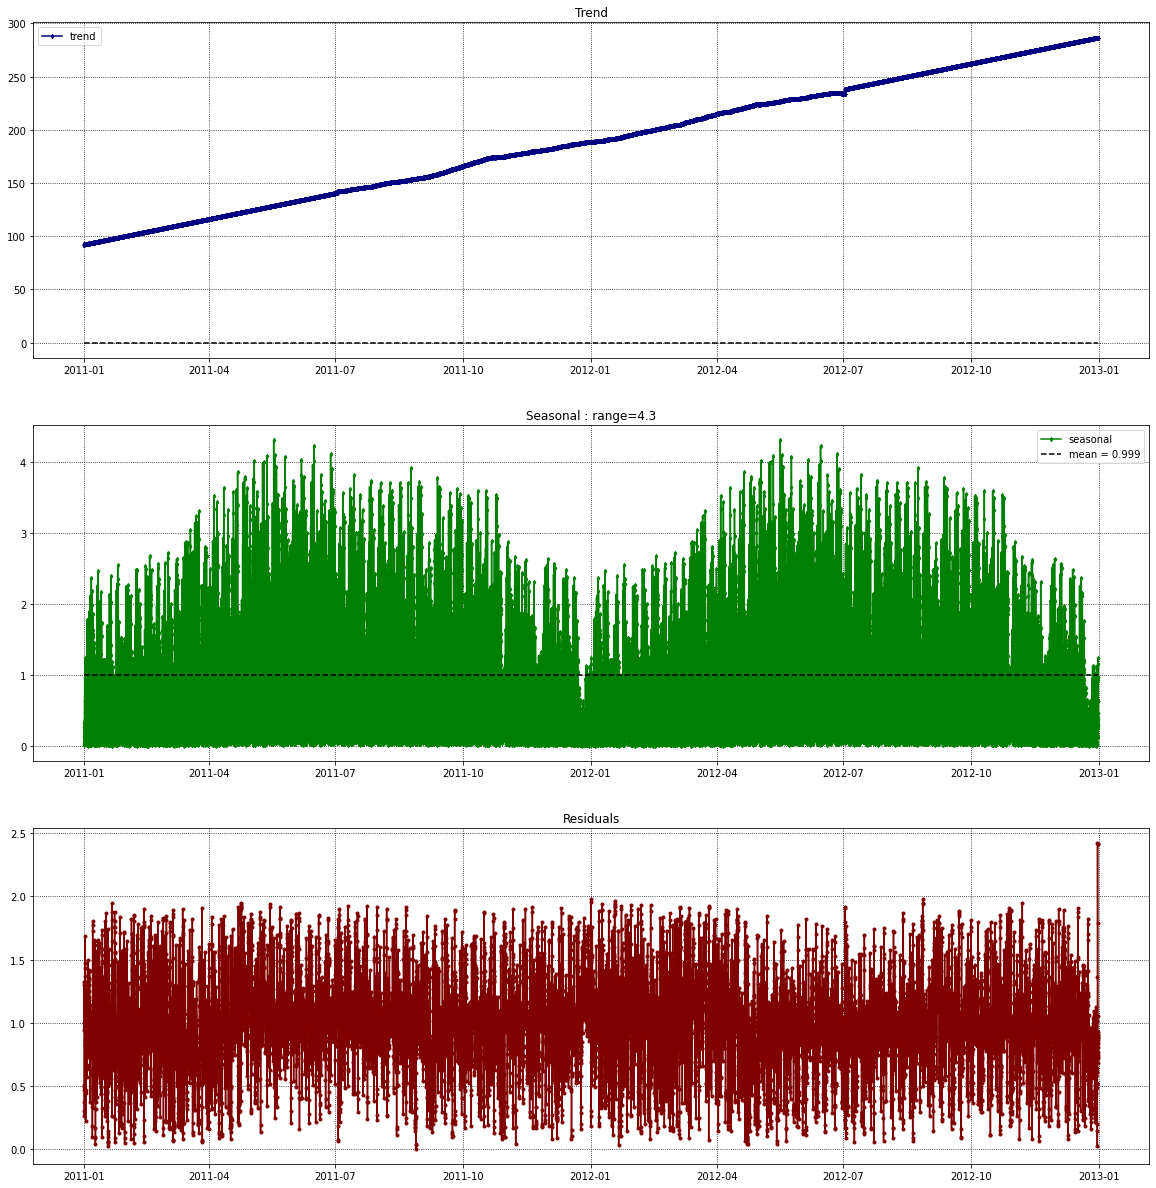

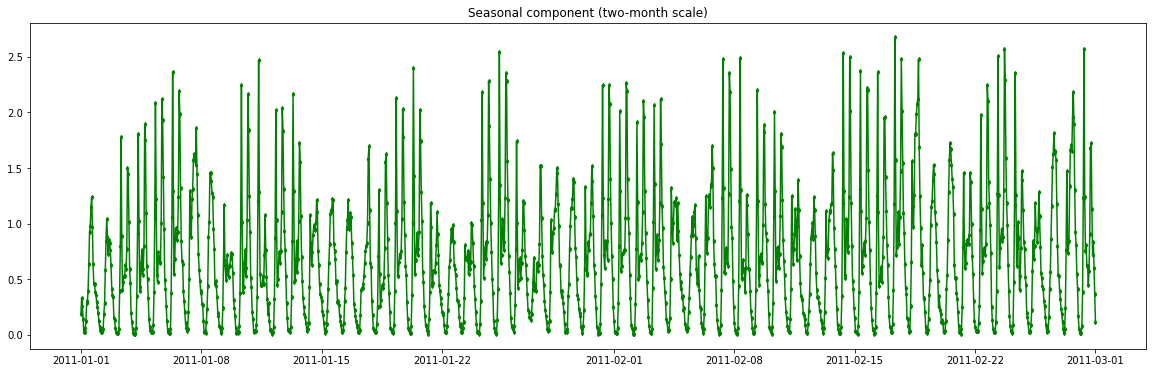

In [ ]:
yearly_component = seasonal_decompose(y, model='multiplicative', period=24*365, extrapolate_trend='freq')
yearly_seasonal = yearly_component.seasonal
decomp_plot(yearly_component)

We can see a distinct seasonal pattern and a growing trend on plots above.

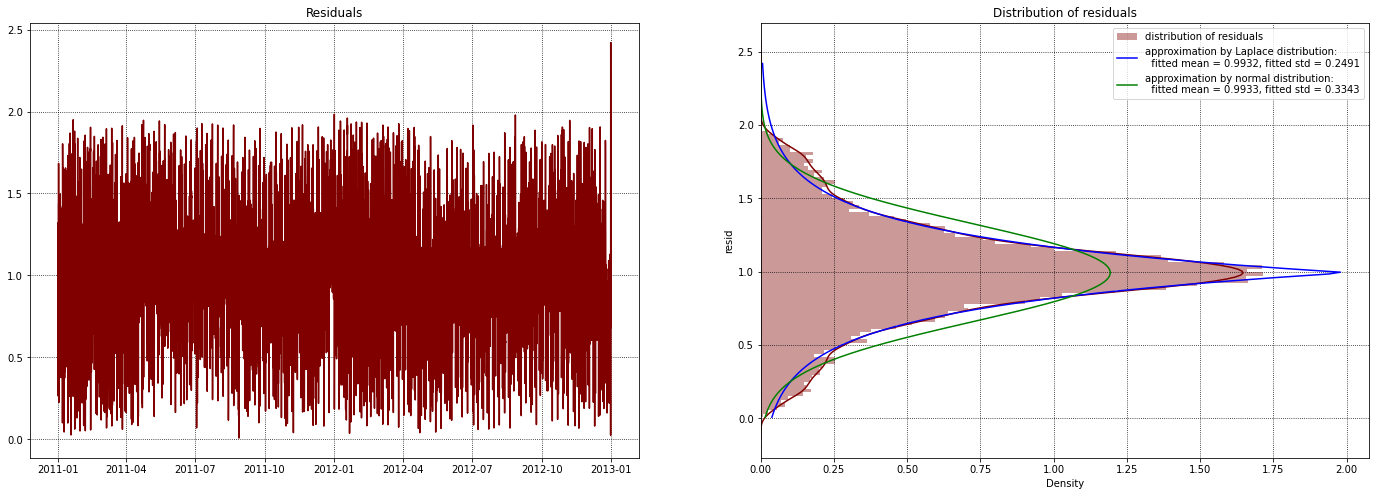

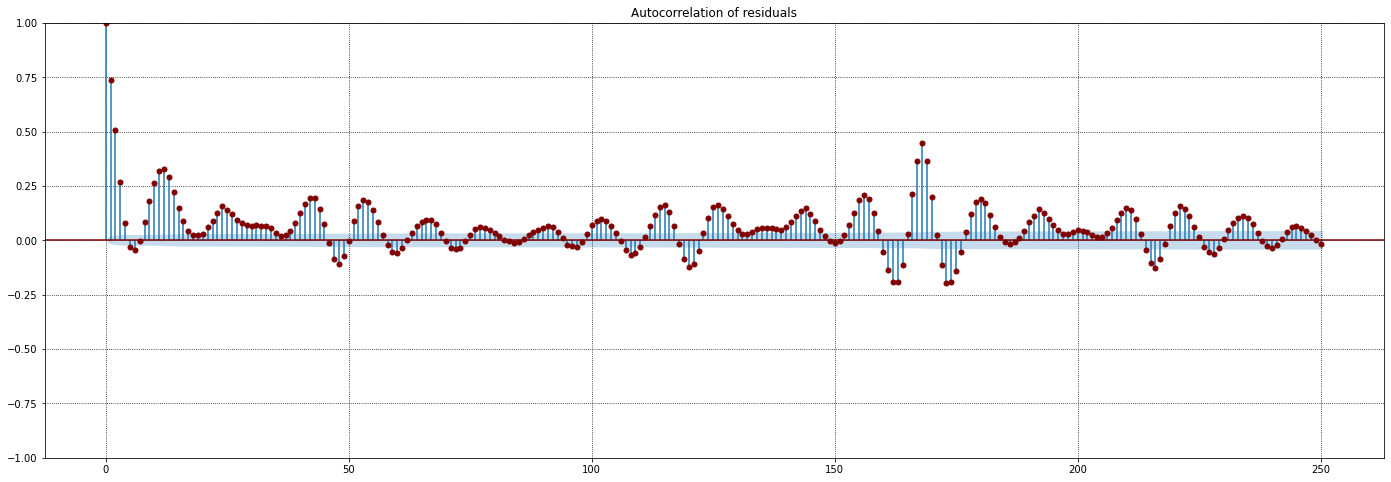

In [ ]:
resid = yearly_component.resid
resid_analisys(resid)

Residuals seem to have Laplace distribution and we can see on the autocorrelation plot the most significant point (after the first and the second lags) - near 168 which is a number of hours in a week. So I assume that we must extract also a weekly component.

To do this we need to subtract yearly seasonal component and yearly trend from the original time series:

In [ ]:
df_no_yearly = df - np.array(yearly_component.seasonal).reshape(-1,1) - np.array(yearly_component.trend).reshape(-1,1)

Then extract the second seasonal component with a period parameter equal 24*7=168. I assume this component is additive as I don't see any significant change in weekly amplitude or frequency over time.

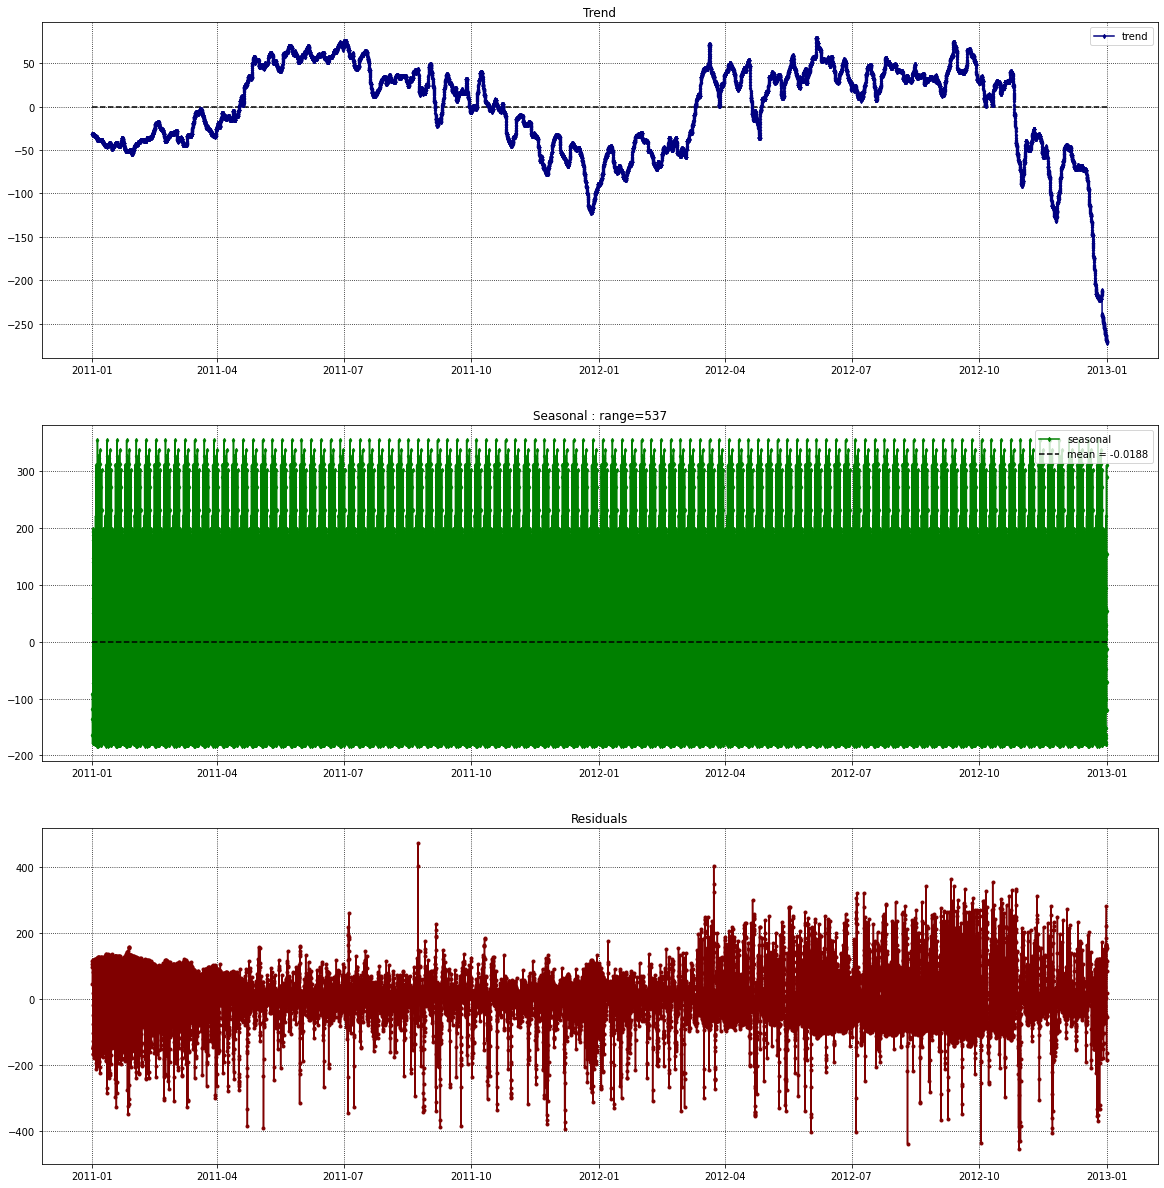

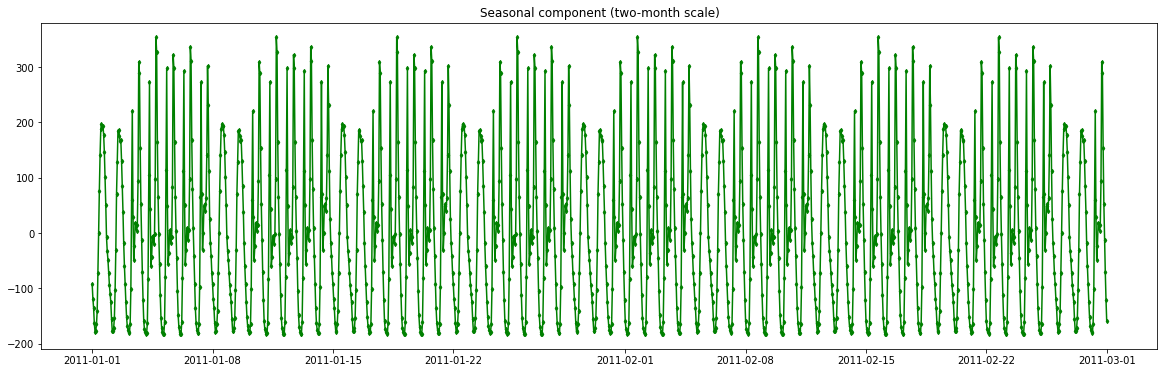

In [ ]:
weekly_component = seasonal_decompose(df_no_yearly, model='additive', period=24*7, extrapolate_trend='freq')
weekly_seasonal = weekly_component.seasonal
decomp_plot(weekly_component)

On the zoomed plot we see a very similar pattern that we saw on the original data. So let's check the residuals:

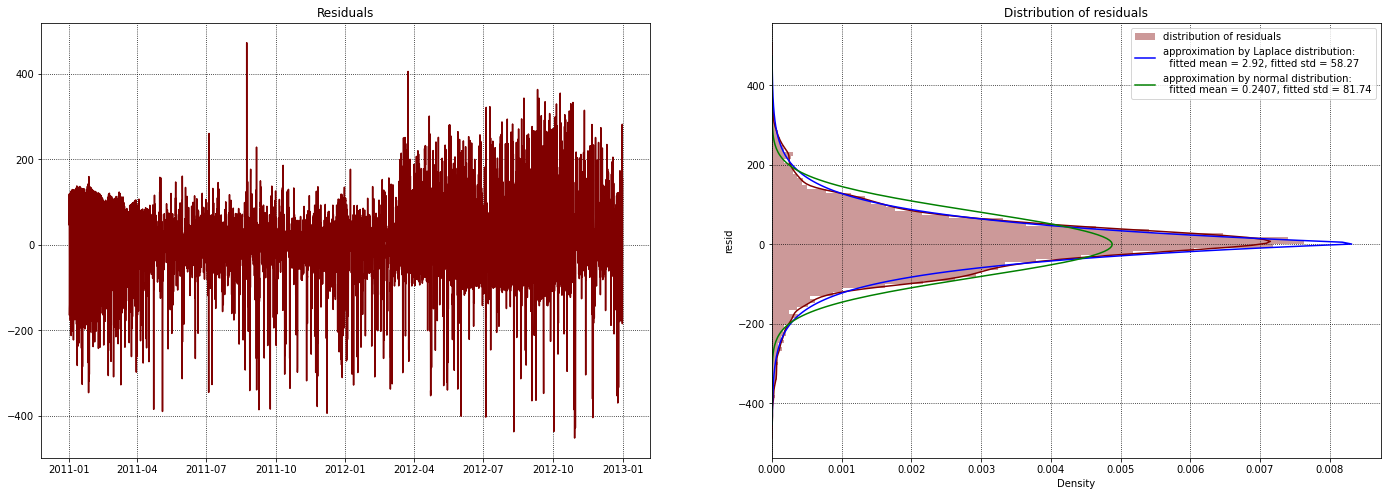

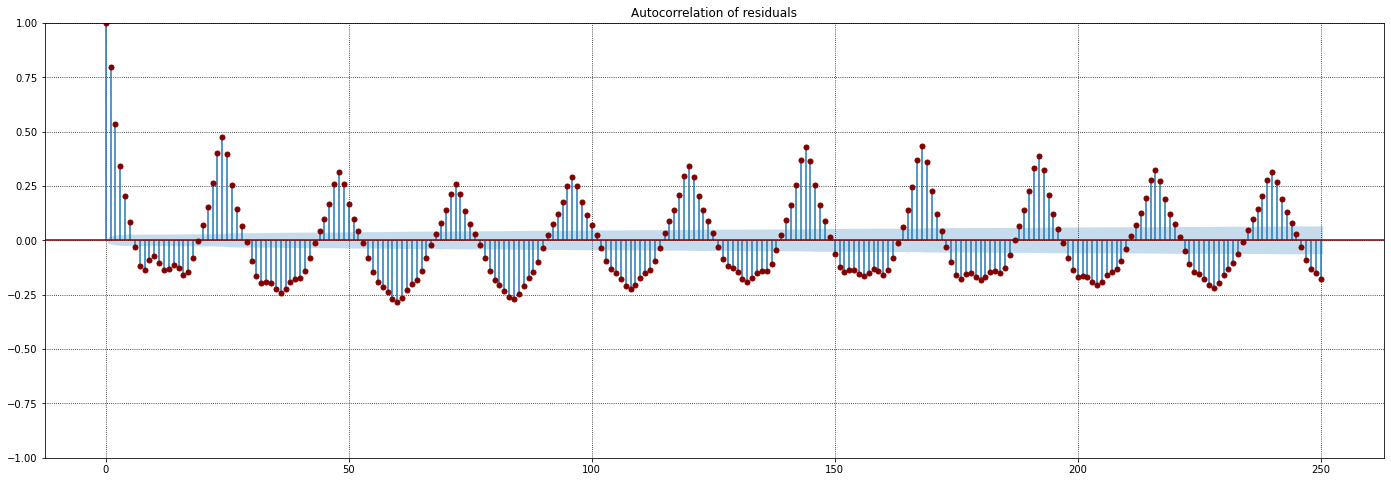

In [ ]:
resid = weekly_component.resid
resid_analisys(resid)

They also have Laplace distribution and again we see a repeating pattern on the autocorrelation plot. Now we have a lot of significant points within a 24-hour distance between each other. This indicates that we need to extract the daily component from the rest of our time series data.

Again subtract already extracted components from the data:

In [ ]:
df_no_yearly_weekly = df_no_yearly - np.array(weekly_component.seasonal).reshape(-1,1) - np.array(weekly_component.trend).reshape(-1,1)

Then perform a decomposition:

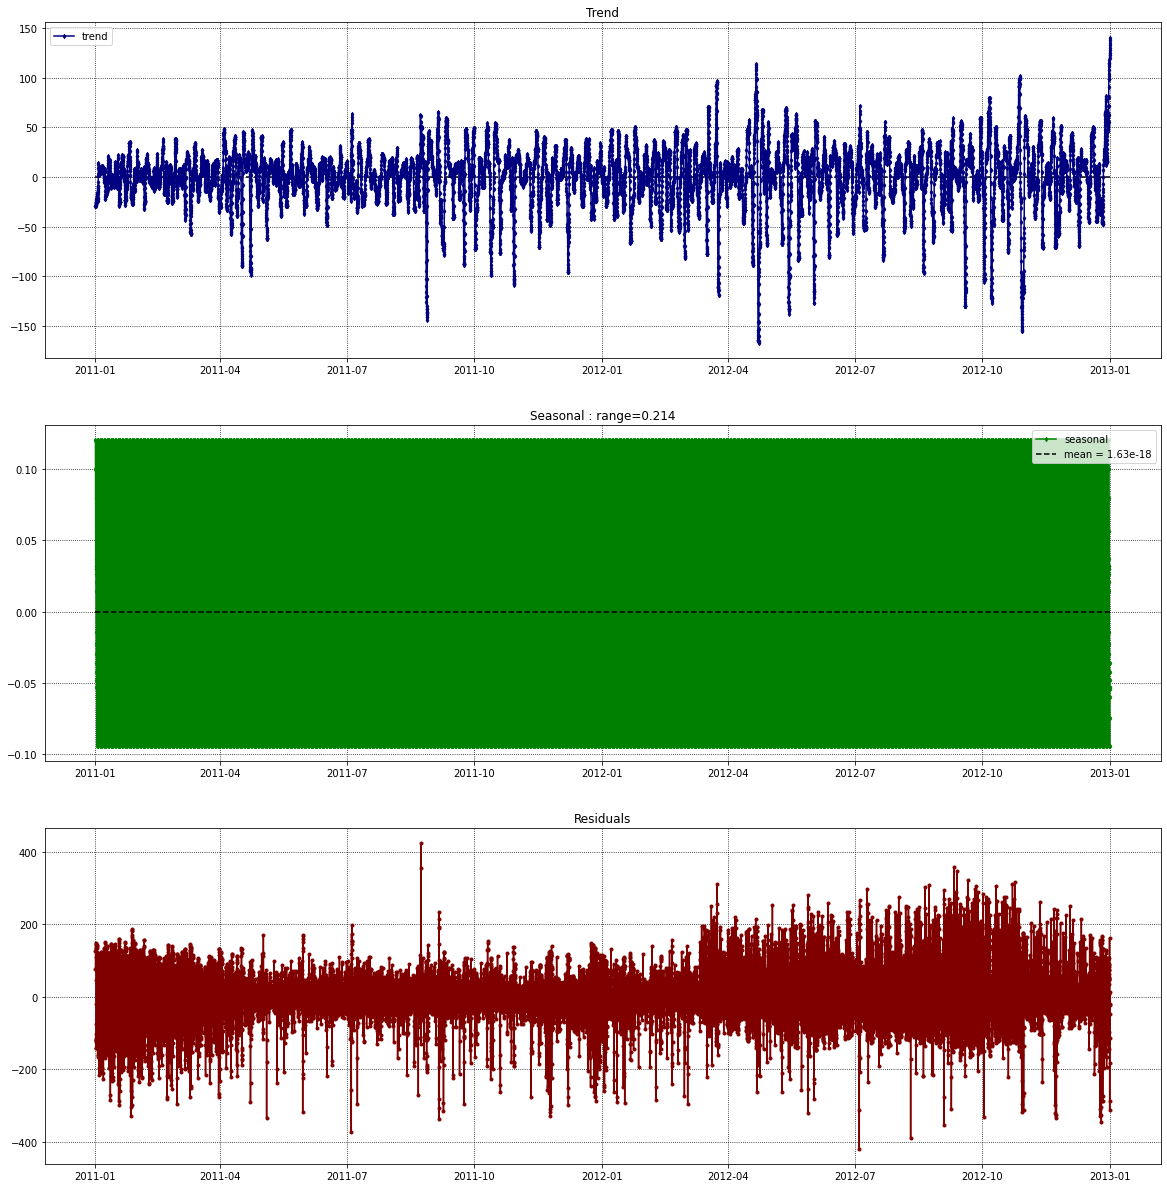

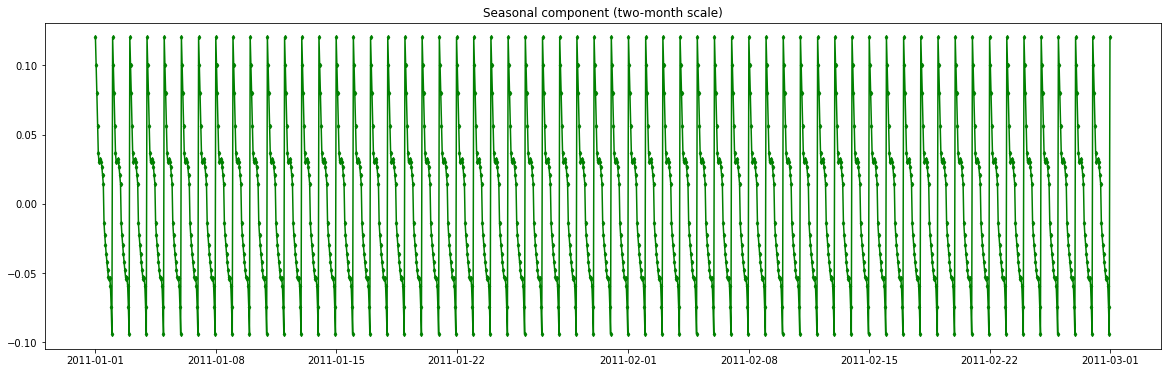

In [ ]:
daily_comp = seasonal_decompose(df_no_yearly_weekly, model='additive', period=24, extrapolate_trend='freq')
decomp_plot(daily_comp)

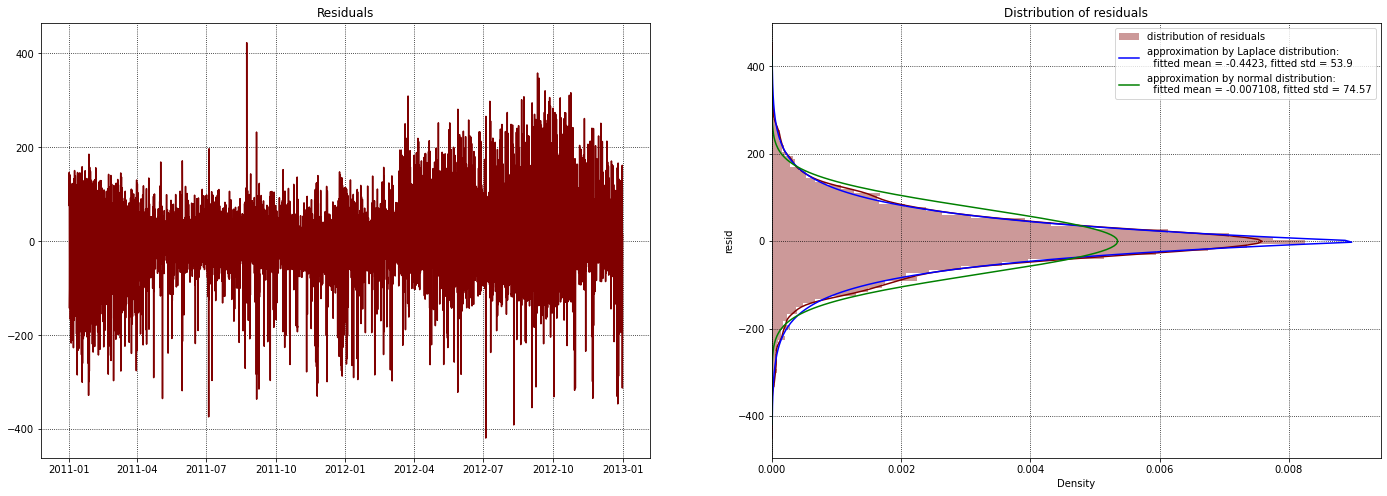

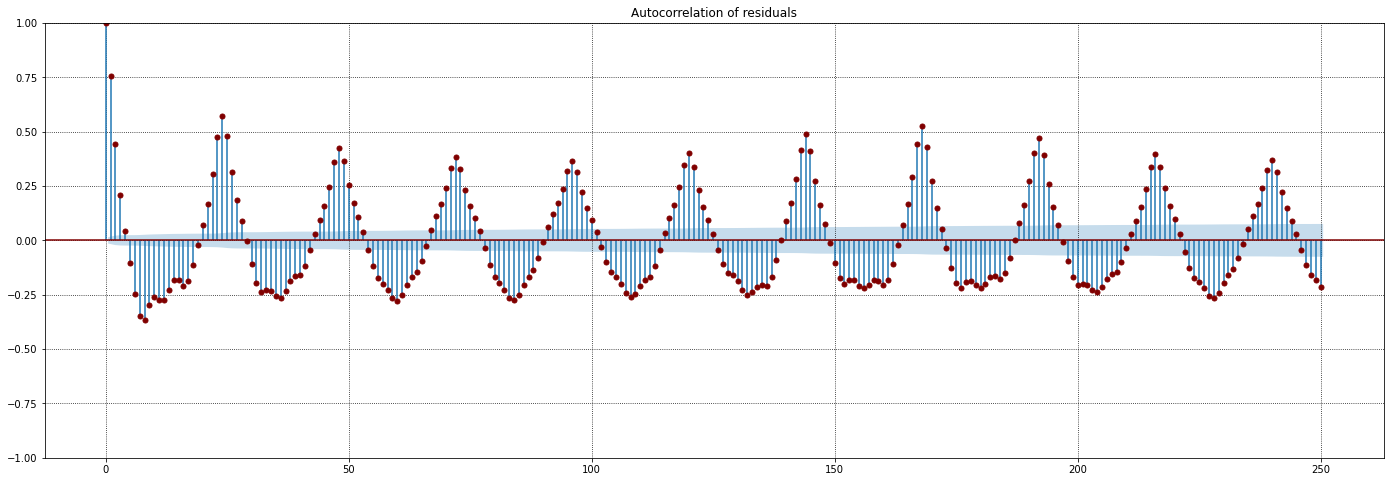

In [ ]:
resid = daily_comp.resid
resid_analisys(resid)

Surprisingly there is again a regular pattern with a 24-hour length in the residuals autocorrelation function. This result quite confuse me as I expected residuals to be more of a noise after extracting three seasonal components from the series. I assume that there might be other seasonalities in the data that I didn't catch. Or probably I have done something wrong. Looking forward to comments on this from the mentor.

###Test for trend stationarity

Next, let's look at our cumulative trend which we will get by summing up all trends we got by decomposition, and check it for stationarity:

In [ ]:
trend = daily_comp.trend.dropna() + weekly_component.trend.dropna() + yearly_component.trend.dropna()

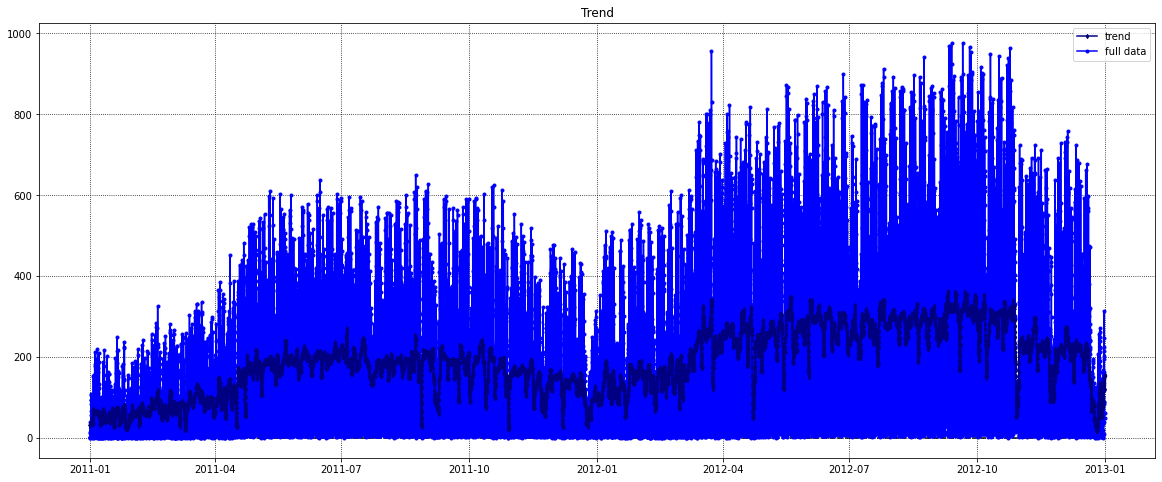

In [ ]:
plt.subplots(1, 1, figsize=(20, 8))

plt.plot(trend, '-d', color='navy', markersize=3, label='trend', zorder=10)
plt.plot(df, '-bo', markersize=3, label='full data', zorder=5)
plt.plot([trend.index[0], trend.index[-1]], [0, 0], '--k')
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title("Trend")
plt.show()

In [ ]:
adf_test(trend)

alpha = 0.05

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -5.199
p-value: 8.848e-06
The process is stationary.


In [ ]:
kpss_test(trend)

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 11.33
p-value = 0.01
The process is non-stationary.


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




Again we got a situation when KPSS indicates non-stationarity and ADF indicates stationarity. This means the trend is difference stationary. Differencing is to be used to make it stationary. Let's differentiate it and check stationarity again:

Text(0.5, 1.0, '1st derivative of trend')

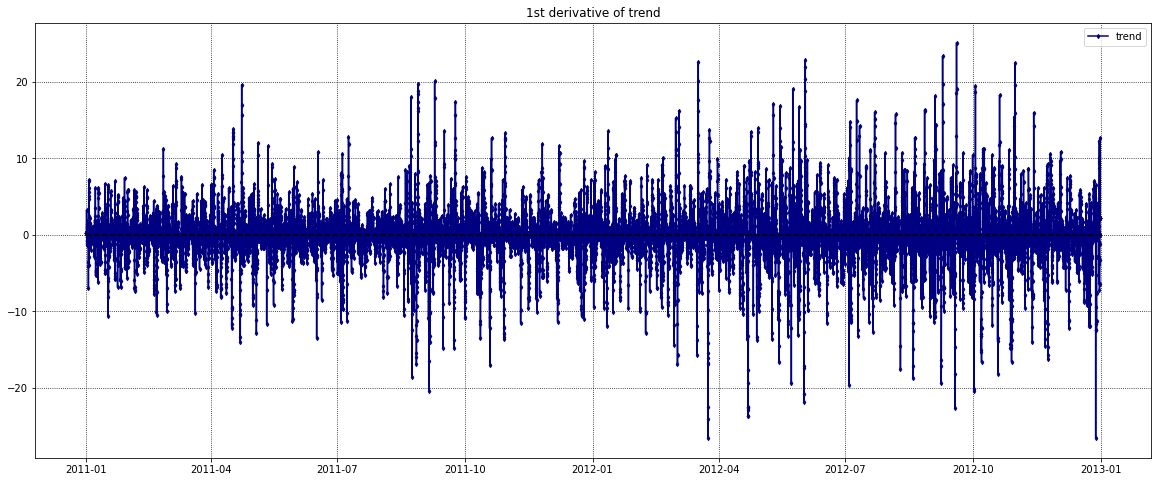

In [ ]:
trend_diff = trend.diff().dropna()

plt.subplots(1, 1, figsize=(20, 8))

plt.plot(trend_diff, '-d', color='navy', markersize=3, label='trend')
plt.plot([trend_diff.index[0], trend_diff.index[-1]], [0, 0], '--k')
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title("1st derivative of trend")

In [ ]:
adf_test(trend_diff)

alpha = 0.05

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -24.77
p-value: 0
The process is stationary.


In [ ]:
kpss_test(trend_diff)

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 0.01551
p-value = 0.1
The process is stationary.


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




First difference of the trend is stationary.

##Decomposition of the first difference (derivative)

As an experiment I would like to decompose the first difference of our original data to it's seasonal components:

In [ ]:
y = df['cnt'].diff().dropna()

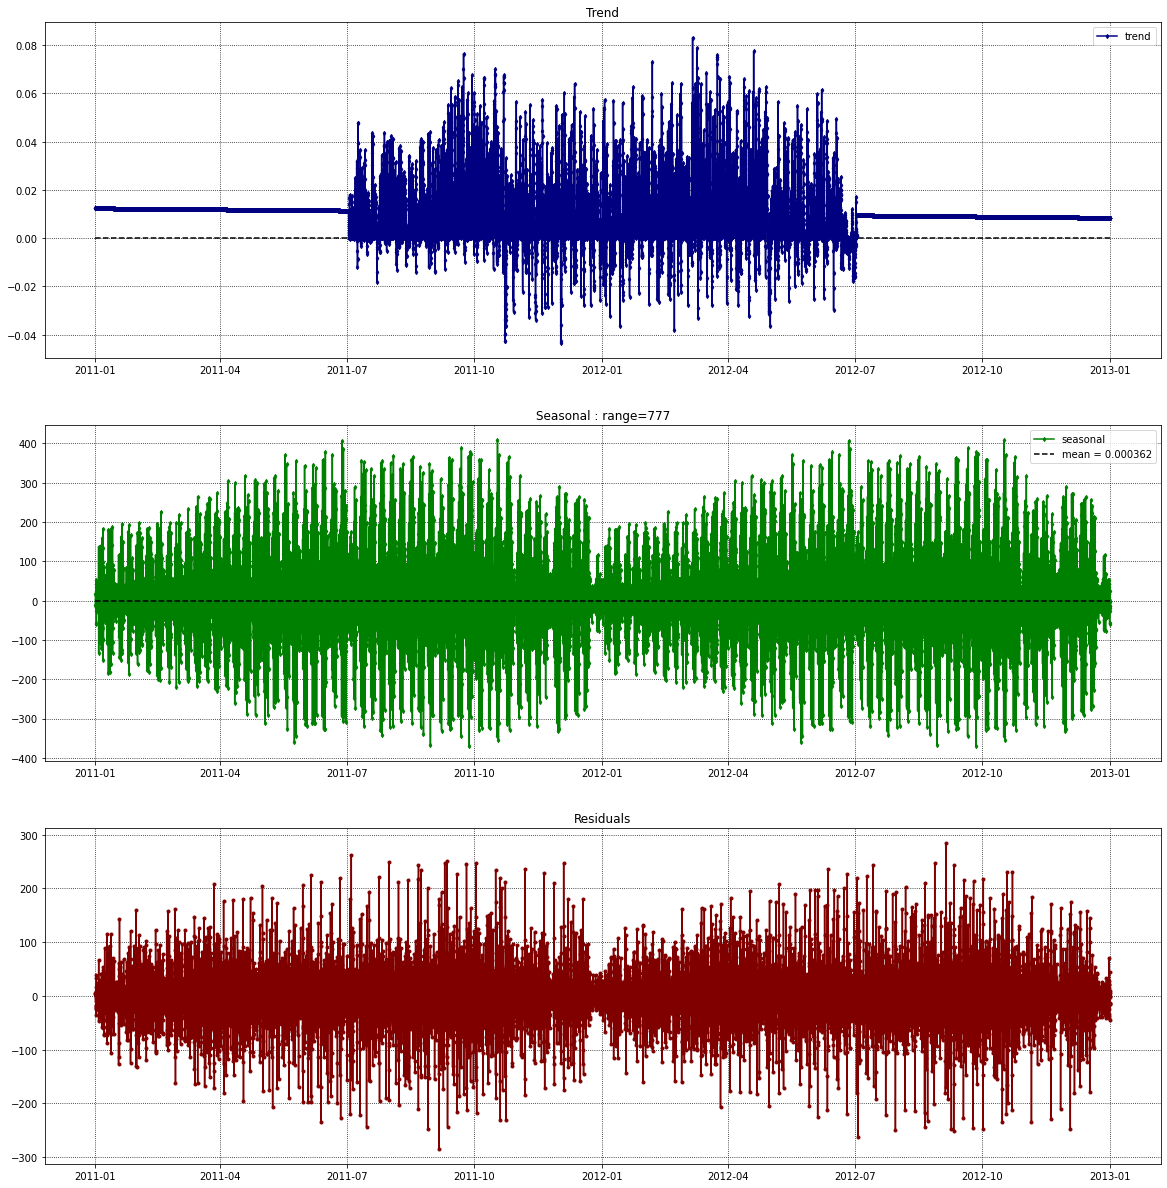

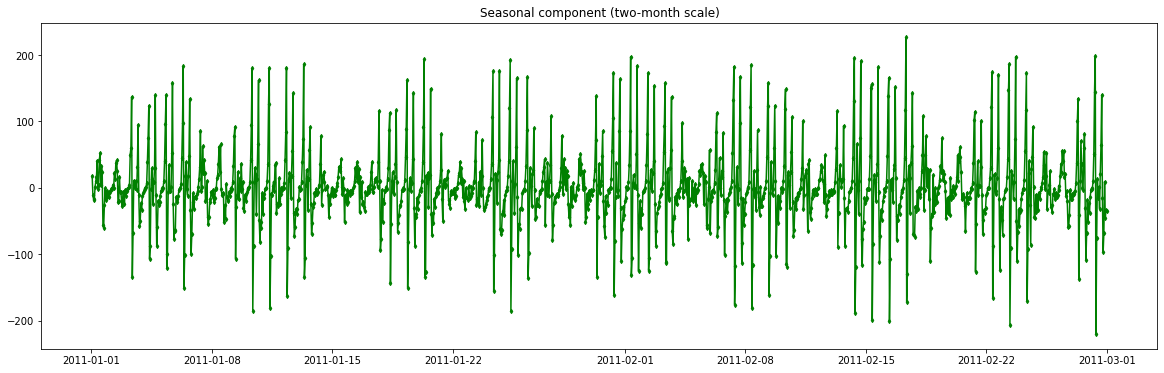

In [ ]:
diff_yearly_dec = seasonal_decompose(y, model='additive', period=24*365, extrapolate_trend='freq')
decomp_plot(diff_yearly_dec)

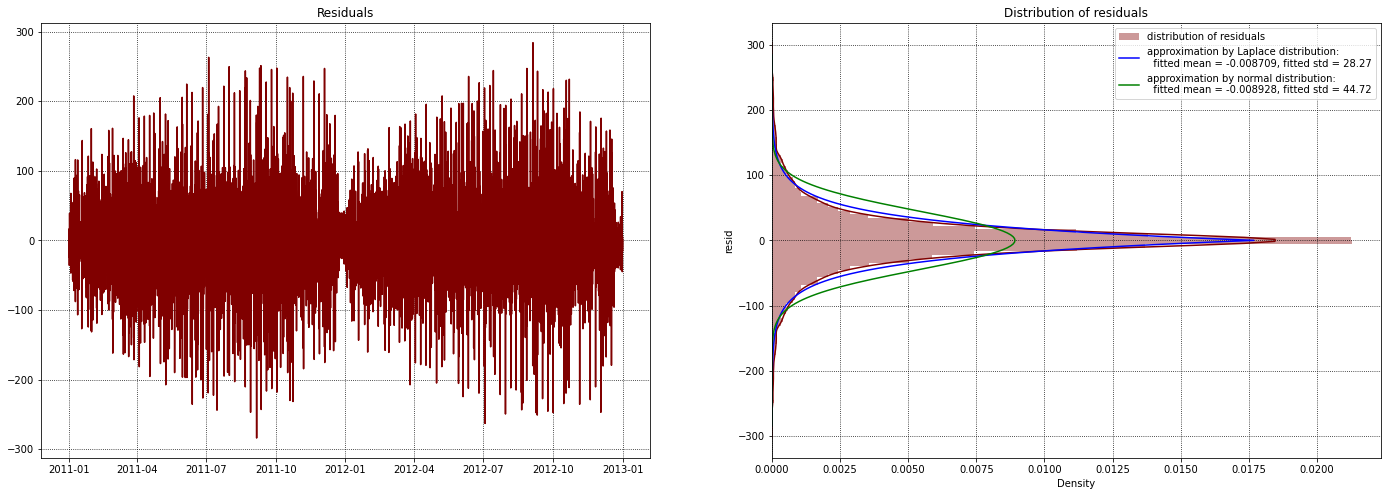

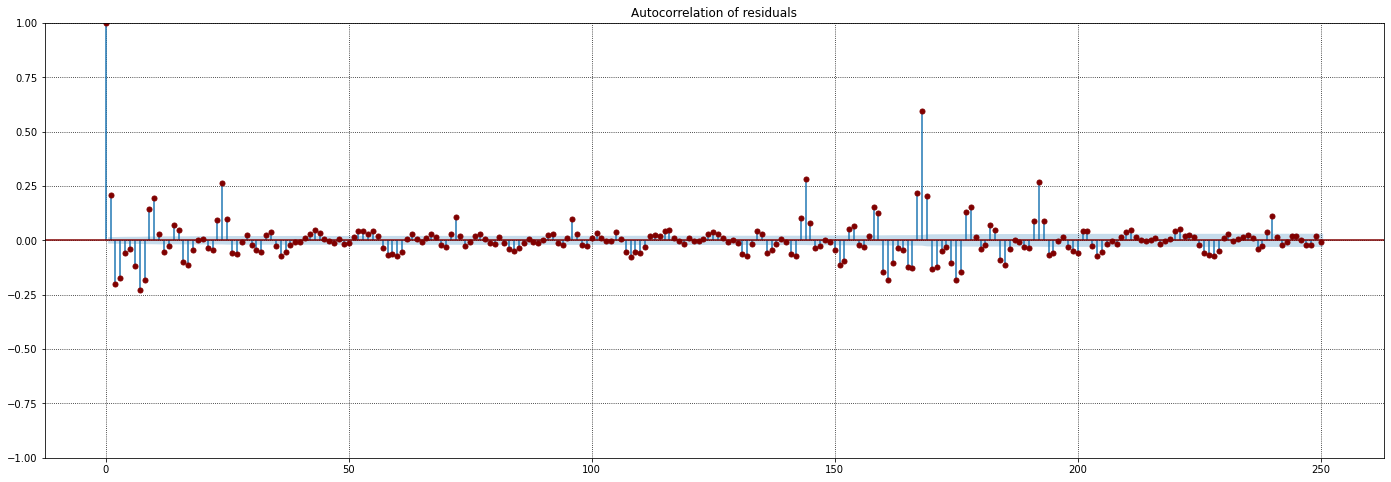

In [ ]:
resid = diff_yearly_dec.resid
resid_analisys(resid)

In [ ]:
y_1 = y - diff_yearly_dec.seasonal - diff_yearly_dec.trend
diff_weekly_dec = seasonal_decompose(y_1, model='additive', period=24*7, extrapolate_trend='freq')

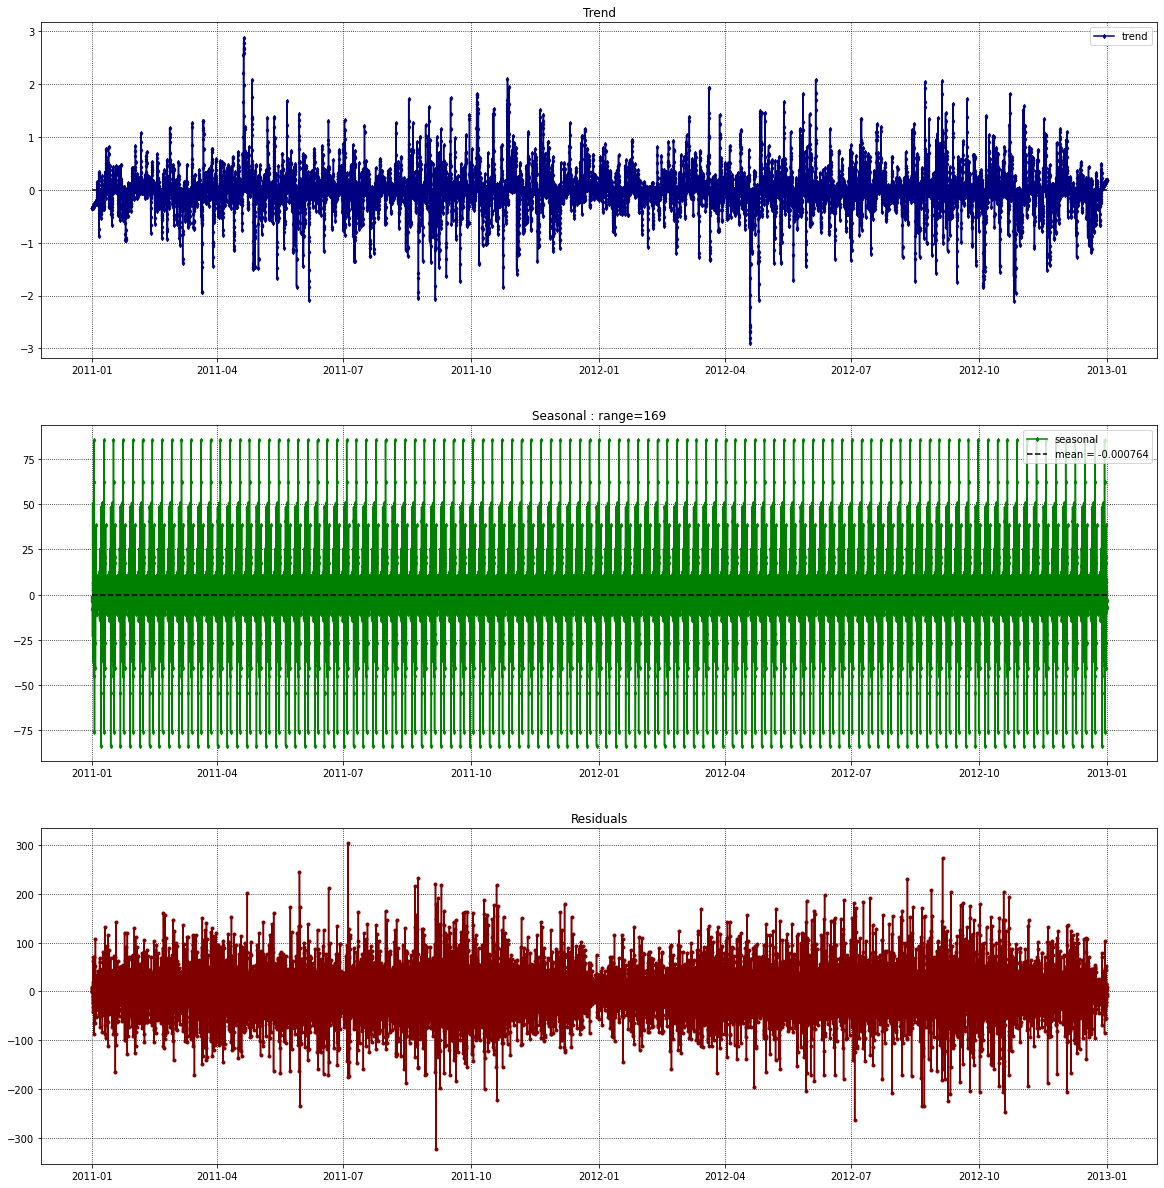

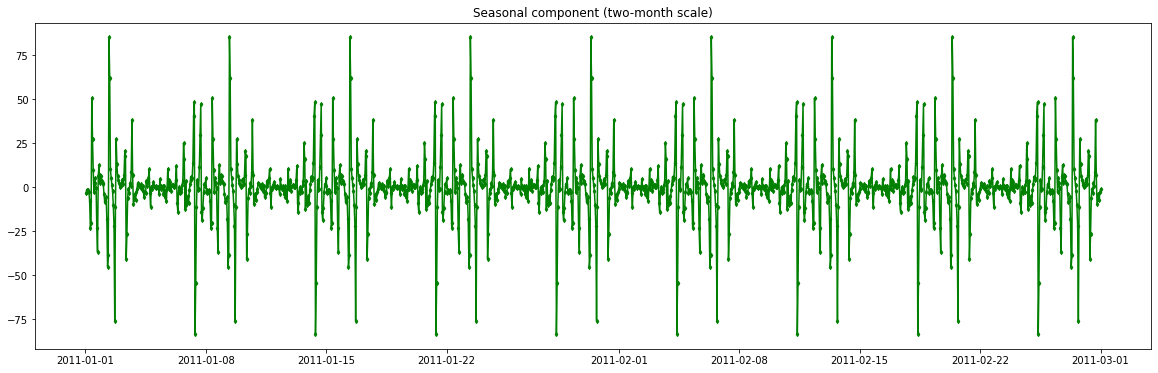

In [ ]:
decomp_plot(diff_weekly_dec)

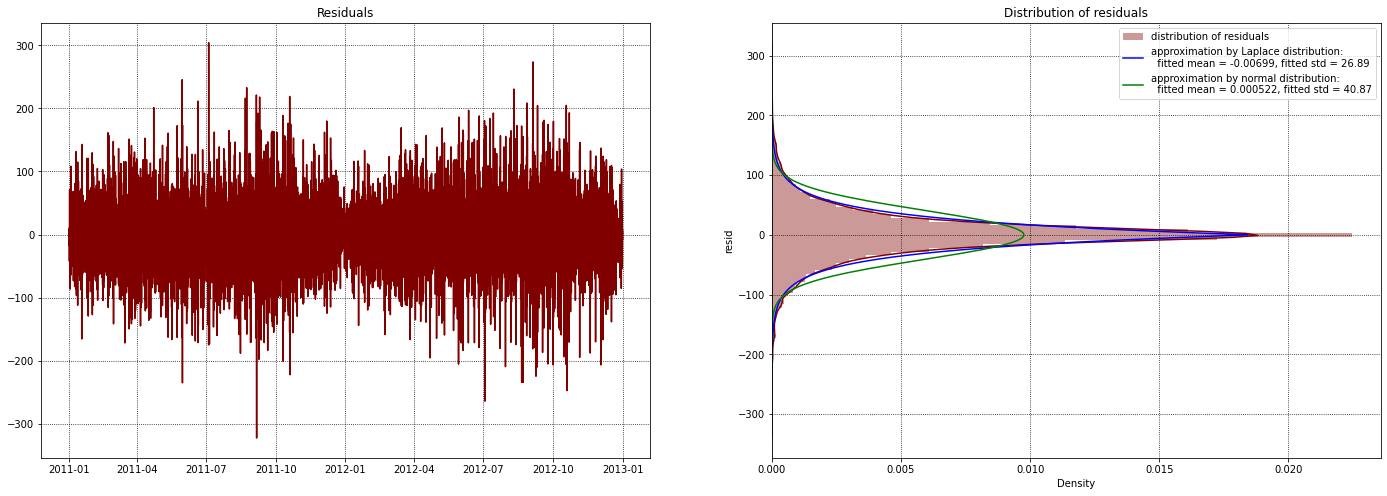

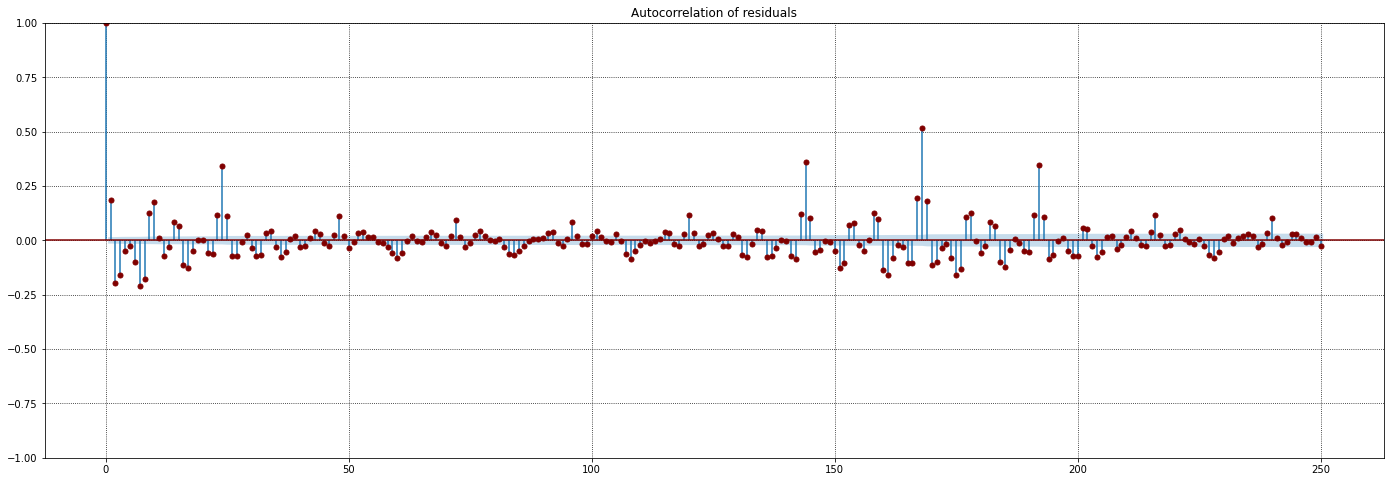

In [ ]:
resid = diff_weekly_dec.resid
resid_analisys(resid)

In [ ]:
y_2 = y_1 - diff_weekly_dec.seasonal - diff_weekly_dec.trend
diff_daily_dec = seasonal_decompose(y_2, model='additive', period=24, extrapolate_trend='freq')

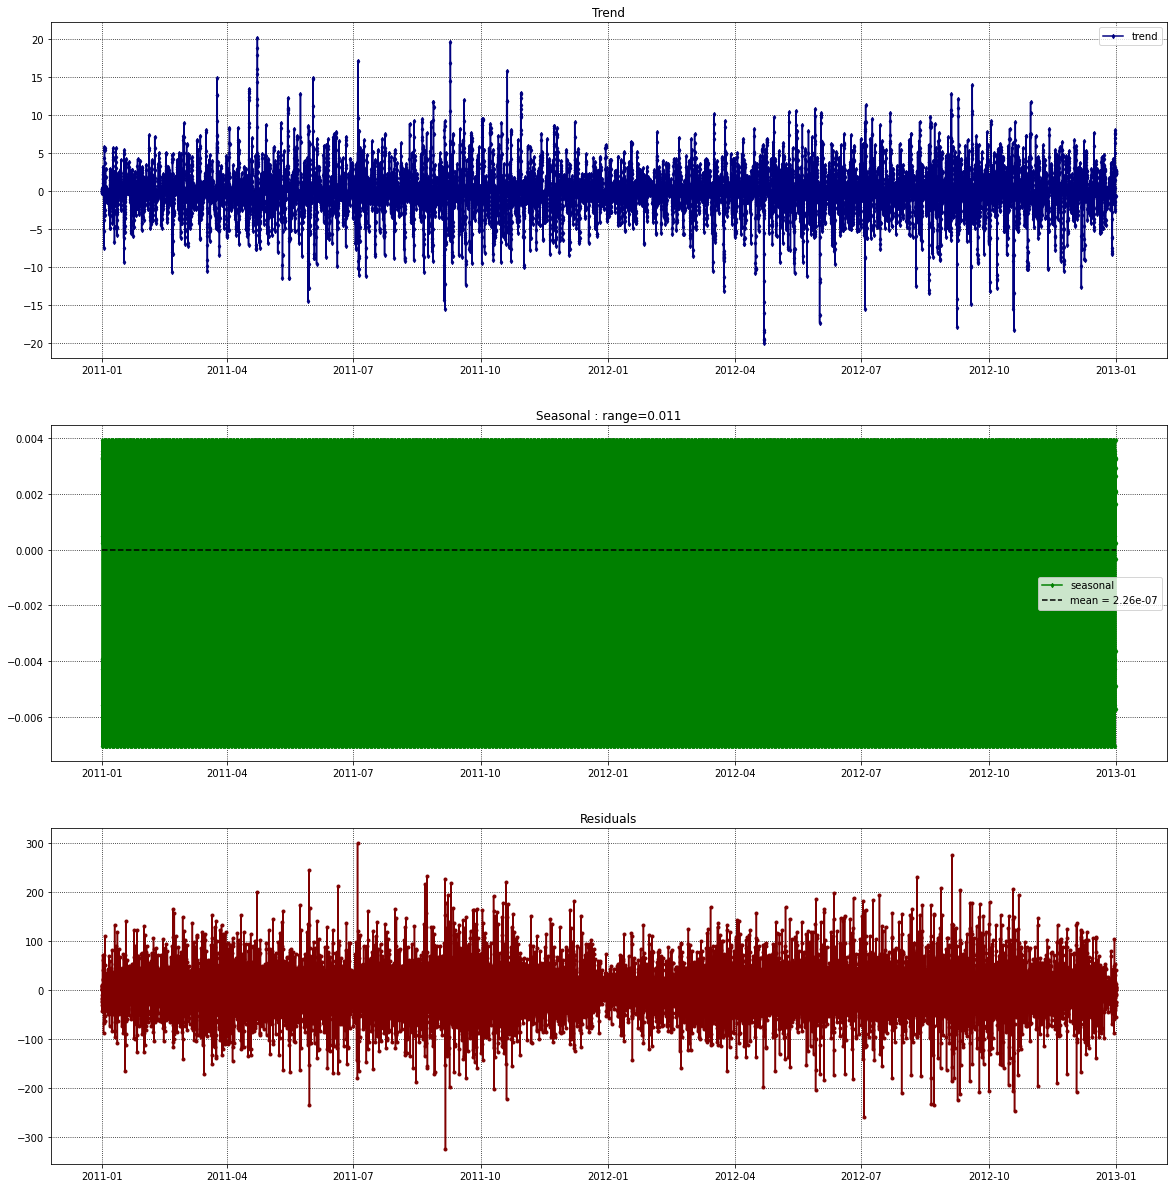

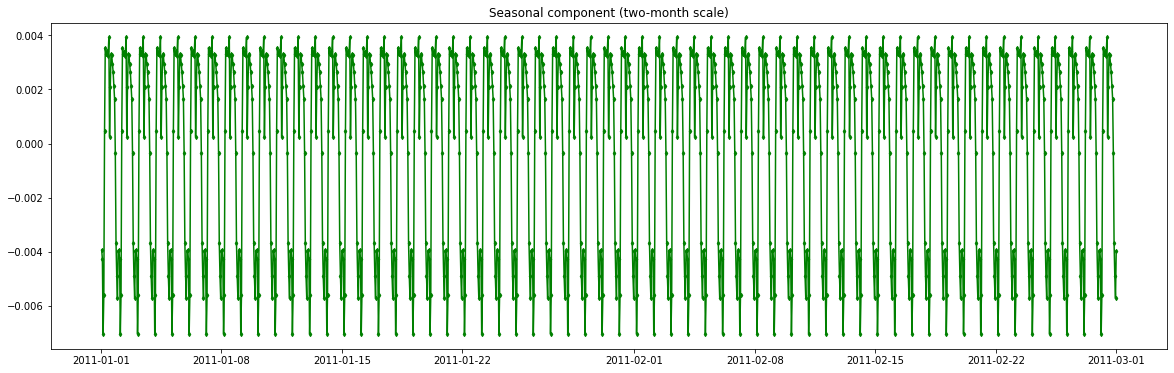

In [ ]:
decomp_plot(diff_daily_dec)

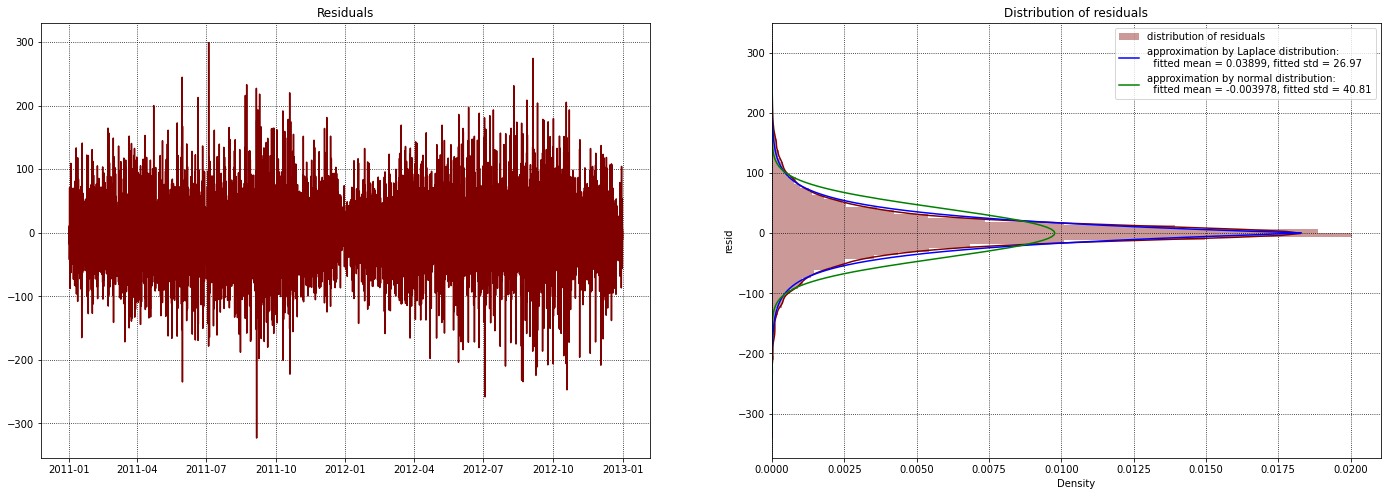

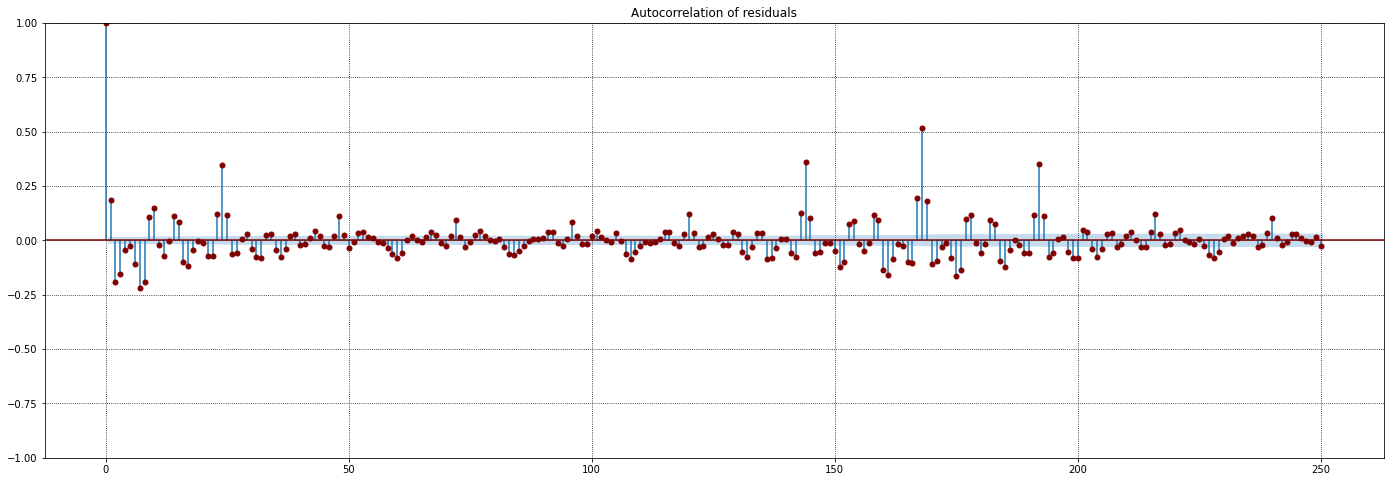

In [ ]:
resid = diff_daily_dec.resid
resid_analisys(resid)

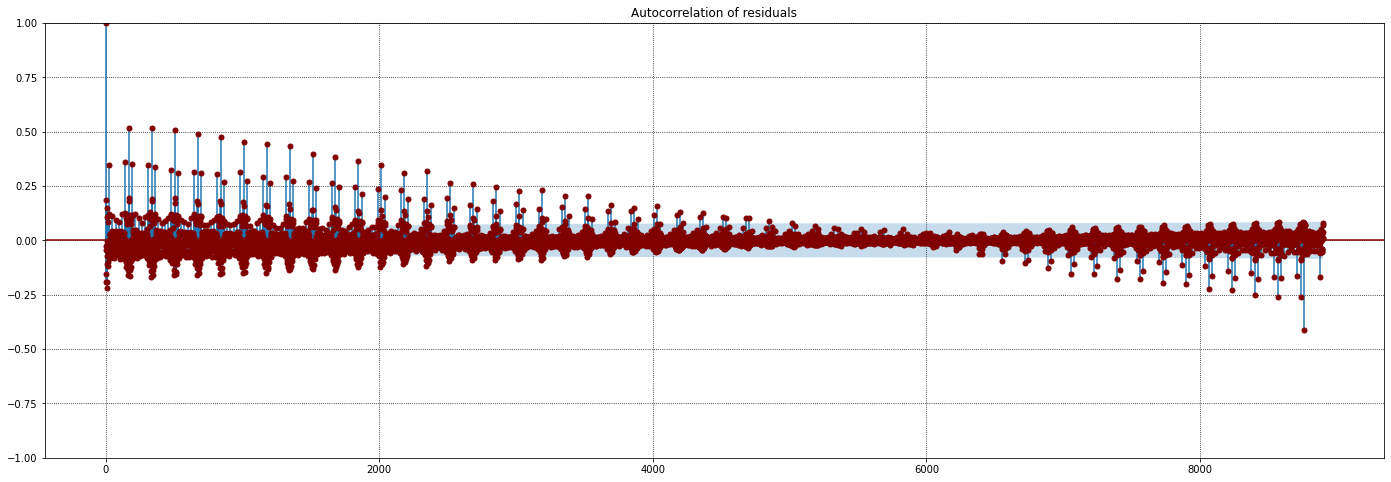

In [ ]:
  lags = 8900
  fig, ax = plt.subplots(figsize=(24, 8))
  plot_acf(resid.dropna(), lags=lags, color='maroon',
          title='Autocorrelation of residuals', ax=ax);
  plt.grid(linestyle=':', color='k')
  plt.show()


Even when I decomposed the difference of the time series which is stationary as I assured before I got a similar picture of the residuals - they have 24-hour autocorrelation structure. Probably it needed extraction of another seasonality.

##Autocorrelation Analysis (of first difference)

In [ ]:
def autocorrelation_analysis(y, decomposition):
  N = len(y)
  k = np.arange(0, N)
  fig, ax = plt.subplots(figsize=(24, 8))
  plot_acf(y,
          lags=N-1,
          vlines_kwargs={'color' : 'b'},
          markerfacecolor='b', markeredgecolor='b',
          title='Autocorrelation of target', ax=ax);
  plt.plot(k, 1-k/N, ':r')
  plt.plot(k, -1+k/N, ':r')

  trend = decomposition.trend.dropna()
  N = len(trend)
  k = np.arange(0, N)
  fig, ax = plt.subplots(figsize=(24, 8))
  plot_acf(trend,
          lags=N-1,
          vlines_kwargs={'color' : 'navy'},
          markerfacecolor='navy', markeredgecolor='navy',
          title='Autocorrelation of trend', ax=ax);
  plt.plot(k, 1-k/N, ':r')
  plt.plot(k, -1+k/N, ':r')


  seasonal = decomposition.seasonal
  N = len(seasonal)
  k = np.arange(0, N)
  fig, ax = plt.subplots(figsize=(24, 8))
  plot_acf(seasonal,
          lags=N-1,
          vlines_kwargs={'color' : 'g'},
          markerfacecolor='g', markeredgecolor='g',
          title='Autocorrelation of seasonal', ax=ax);
  plt.plot(k, 1-k/N, ':r')
  plt.plot(k, -1+k/N, ':r')


  N = len(resid.dropna())
  k = np.arange(0, N)
  fig, ax = plt.subplots(figsize=(24, 8))
  plot_acf(resid.dropna(),
          lags=N-1,
          vlines_kwargs={'color' : 'maroon'},
          markerfacecolor='maroon', markeredgecolor='maroon',
          title='Autocorrelation of residuals', ax=ax);
  plt.plot(k, 1-k/N, ':r')
  plt.plot(k, -1+k/N, ':r')


  plt.show()

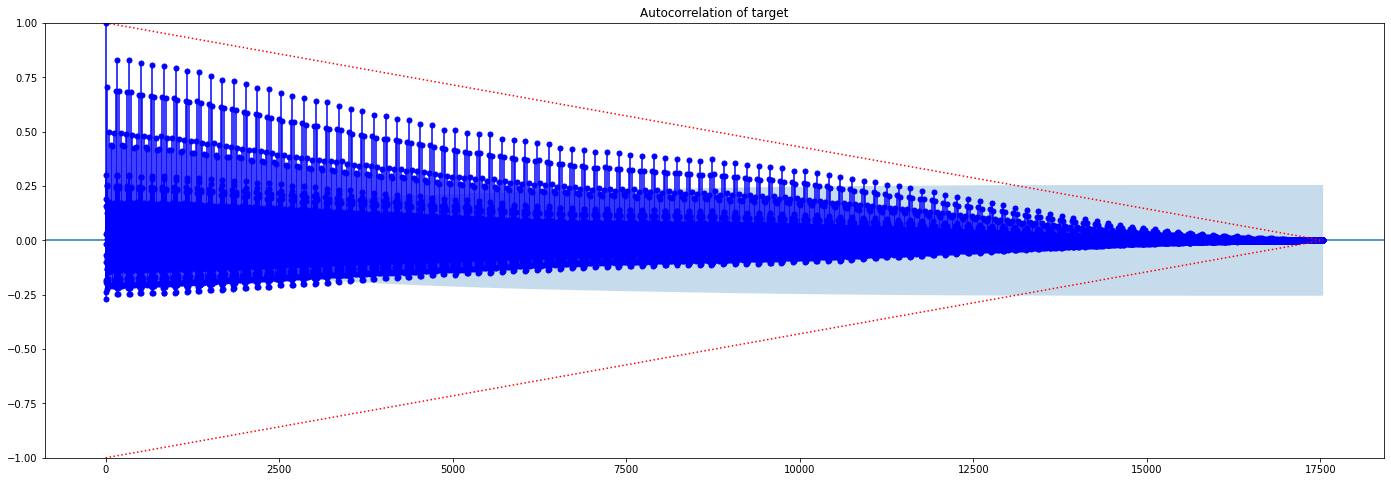

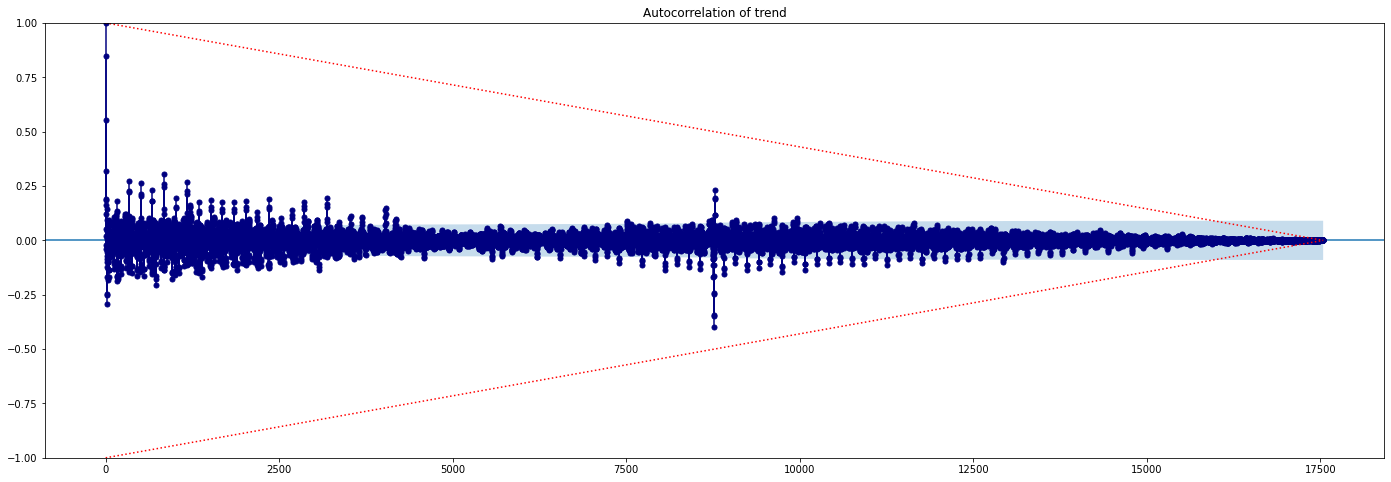

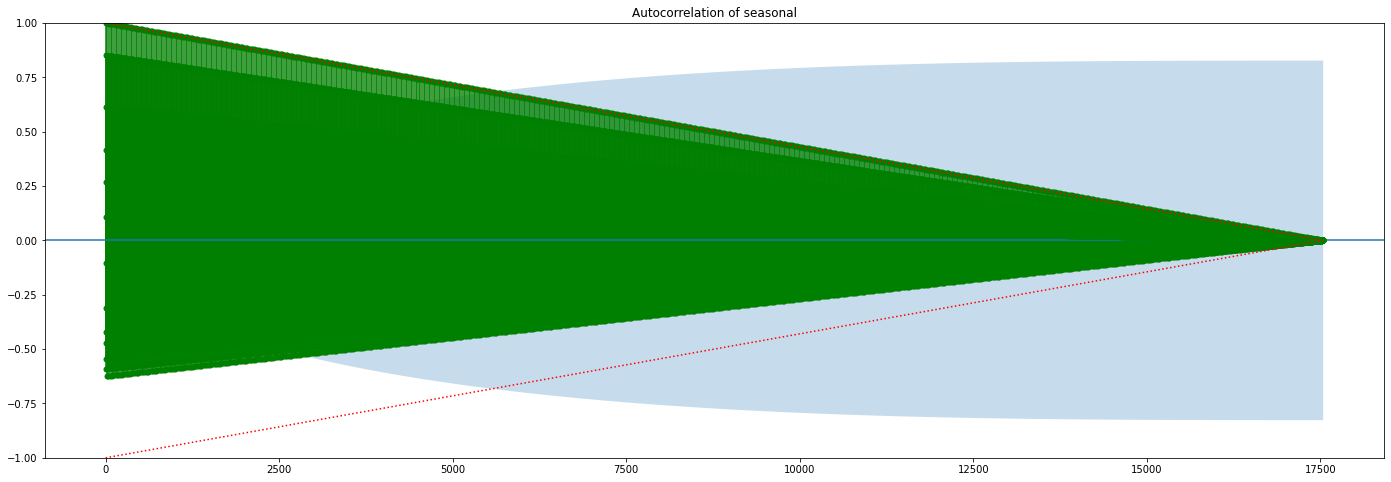

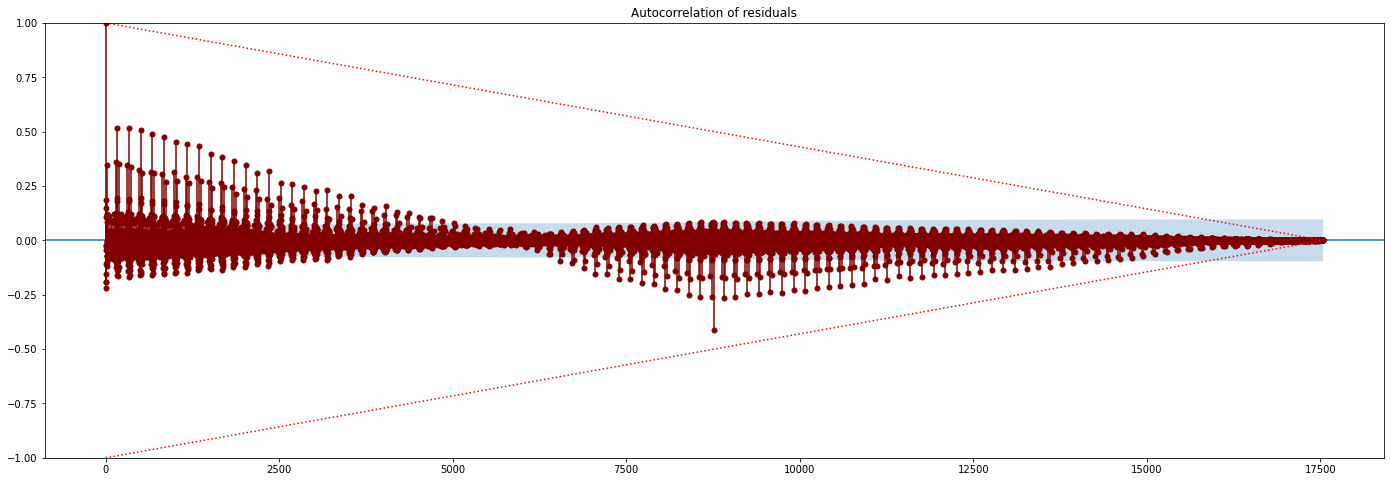

In [ ]:
autocorrelation_analysis(y, diff_daily_dec)

TBD

In [ ]:
def pacf_analysis(y, decomposition, lags=24):

  fig, ax = plt.subplots(figsize=(24, 6))
  plot_pacf(y,
          lags=lags,
          vlines_kwargs={'color' : 'b'},
          markerfacecolor='b', markeredgecolor='b',
          title='Partial autocorrelation of target', ax=ax);

  fig, ax = plt.subplots(figsize=(24, 6))
  plot_pacf(decomposition.trend.dropna(),
          lags=lags,
          vlines_kwargs={'color' : 'navy'},
          markerfacecolor='navy', markeredgecolor='navy',
          title='Partial autocorrelation of trend', ax=ax);

  fig, ax = plt.subplots(figsize=(24, 6))
  seasonal = decomposition.seasonal
  plot_pacf(seasonal,
          lags=lags,
          vlines_kwargs={'color' : 'g'},
          markerfacecolor='g', markeredgecolor='g',
          title='Partial autocorrelation of seasonal', ax=ax);

  fig, ax = plt.subplots(figsize=(24, 6))
  plot_pacf(decomposition.resid.dropna(),
          lags=lags,
          vlines_kwargs={'color' : 'maroon'},
          markerfacecolor='maroon', markeredgecolor='maroon',
          title='Partial autocorrelation of residuals', ax=ax);


  plt.show()

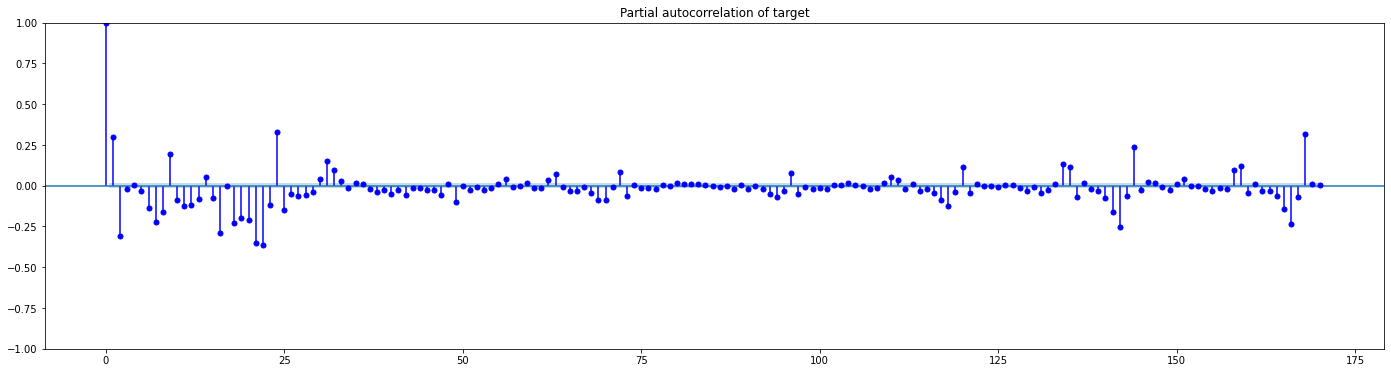

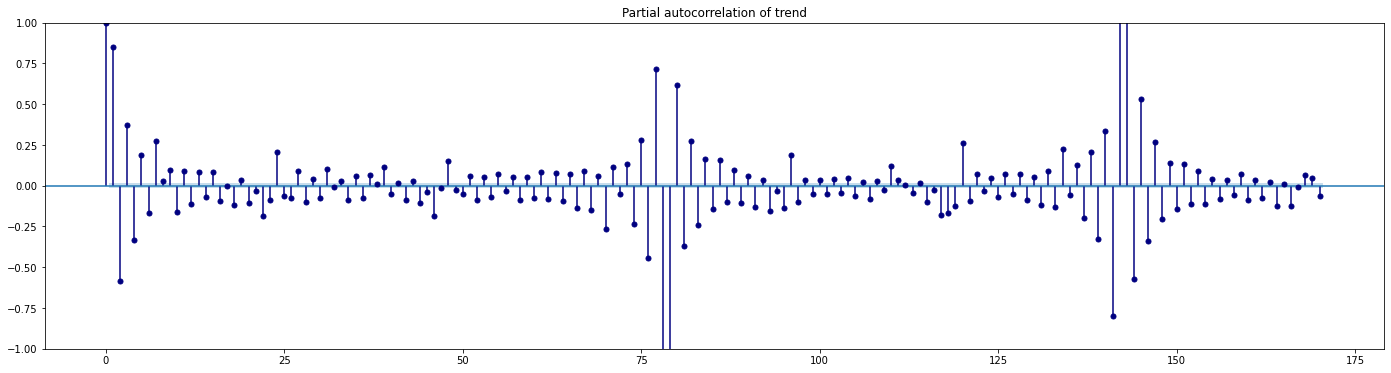

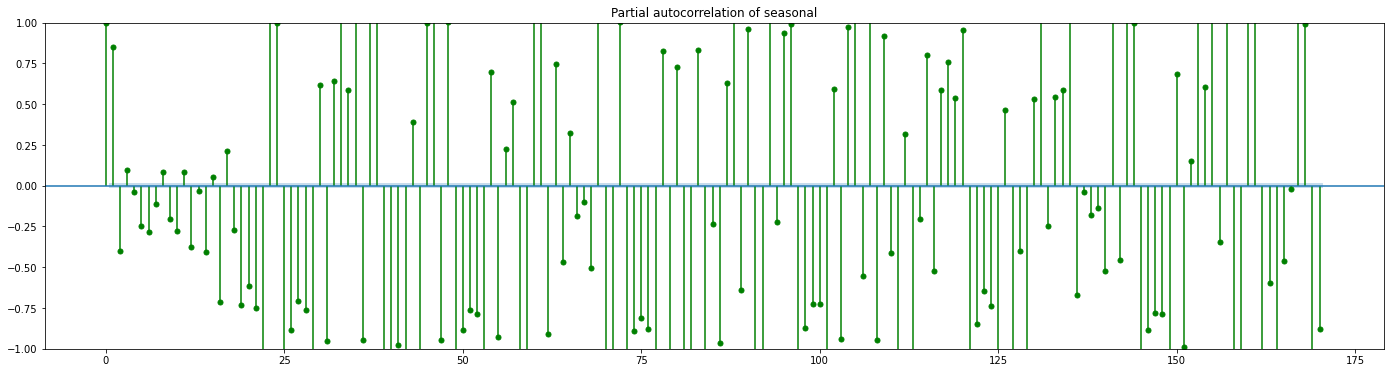

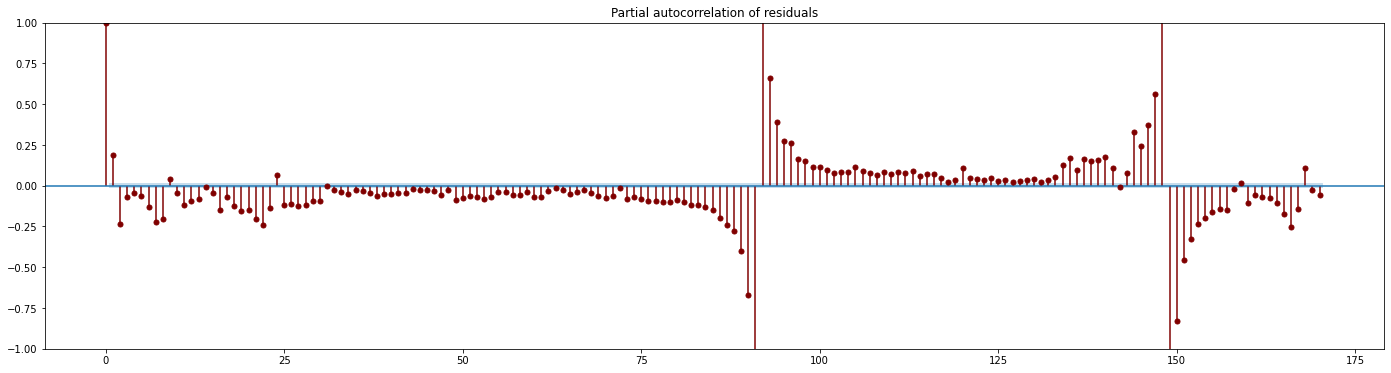

In [ ]:
pacf_analysis(y, diff_daily_dec, 170)

TBD

### Linear Regression

Let's build a baseline Linear Regression model using endogenous features:

In [ ]:
def calc_metrics(y_train, y_test, y_pred_train, y_pred_test):
  # Calculate metrics for given predictions (RMSE, R2, MAE)
  metrics_df = pd.DataFrame({
        'train_RMSE': [np.sqrt(mean_squared_error(y_train, y_pred_train))],
        'test_RMSE': [np.sqrt(mean_squared_error(y_test, y_pred_test))],
        'train_R2': [r2_score(y_train, y_pred_train)],
        'test_R2': [r2_score(y_test, y_pred_test)],
        'train_MAE': [mean_absolute_error(y_train, y_pred_train)],
        'test_MAE': [mean_absolute_error(y_test, y_pred_test)]})
  metrics_df
  return metrics_df

In [ ]:
df_linreg=df_full.copy()
df_linreg.rename(columns={"dteday": "date"}, inplace=True)

In [ ]:
df_linreg = df_linreg.drop(['instant', 'casual', 'registered',], axis=1)

In order to reflect the cyclical nature of time related variables (month, hour, weekday) I will use trigonometric (sin, cos) transformation of these features. Here are the auxiliary functions used for these transformations:

In [ ]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [ ]:
df_linreg['mnth_sin'] = sin_transformer(12).fit_transform(df_linreg['mnth'])
df_linreg['mnth_cos'] = cos_transformer(12).fit_transform(df_linreg['mnth'])
df_linreg['weekday_sin'] = sin_transformer(7).fit_transform(df_linreg['weekday'])
df_linreg['weekday_cos'] = cos_transformer(7).fit_transform(df_linreg['weekday'])
df_linreg['hr_sin'] = sin_transformer(24).fit_transform(df_linreg['hr'])
df_linreg['hr_cos'] = cos_transformer(24).fit_transform(df_linreg['hr'])

Now we have two new features fo each ordinal time feature that together encode equivalent information in a non-monotonic way, and without any jump between the first and the last value of the periodic range.

Defining auxiliary arrays with the names of different kinds of features for further processing:

In [ ]:
cat_cols = ['yr','season', 'holiday', 'workingday']
time_cols = ['mnth', 'weekday', 'hr']
time_modified_cols = ['mnth_sin', 'mnth_cos',  'weekday_sin', 'weekday_cos', 'hr_sin', 'hr_cos']

Encoding categorical features using OneHotEncoder:

In [ ]:
cat_encoded_cols = []
for col in cat_cols:
  val_qty = len(df_linreg[col].unique())
  for i in range(1, val_qty):
     col_name = col + '_' + str(i)
     cat_encoded_cols.append(col_name)
len(cat_encoded_cols)

6

In [ ]:
cat_encoder = OneHotEncoder(drop='first', sparse=False)
cat_encoded = cat_encoder.fit_transform(df_linreg[cat_cols])
df_cat_encoded = pd.DataFrame(cat_encoded, columns=cat_encoded_cols, dtype='int32')

In [ ]:
df_time = df_linreg[time_modified_cols]

Defining X as a concatenation of categorical and time sub-dataframes, and y:

In [ ]:
X = pd.concat([df_time, df_cat_encoded], axis = 1)
y = df_linreg[TARGET]

In [ ]:
X

mnth_sin  mnth_cos  weekday_sin  weekday_cos    hr_sin    hr_cos  \
0      5.000000e-01  0.866025    -0.781831      0.62349  0.000000  1.000000   
1      5.000000e-01  0.866025    -0.781831      0.62349  0.258819  0.965926   
2      5.000000e-01  0.866025    -0.781831      0.62349  0.500000  0.866025   
3      5.000000e-01  0.866025    -0.781831      0.62349  0.707107  0.707107   
4      5.000000e-01  0.866025    -0.781831      0.62349  0.866025  0.500000   
...             ...       ...          ...          ...       ...       ...   
17374 -2.449294e-16  1.000000     0.781831      0.62349 -0.965926  0.258819   
17375 -2.449294e-16  1.000000     0.781831      0.62349 -0.866025  0.500000   
17376 -2.449294e-16  1.000000     0.781831      0.62349 -0.707107  0.707107   
17377 -2.449294e-16  1.000000     0.781831      0.62349 -0.500000  0.866025   
17378 -2.449294e-16  1.000000     0.781831      0.62349 -0.258819  0.965926   

       yr_1  season_1  season_2  season_3  holiday_1  workingday_1  
0         0         0         0         0          0             0  
1         0         0         0         0          0             0  
2         0         0         0         0          0             0  
3         0         0         0         0          0             0  
4         0         0         0         0          0             0  
...     ...       ...       ...       ...        ...           ...  
17374     1         0         0         0          0             1  
17375     1         0         0         0          0             1  
17376     1         0         0         0          0             1  
17377     1         0         0         0          0             1  
17378     1         0         0         0          0             1  

[17379 rows x 12 columns]

Splitting for train and test datasets. Test sample is the last month of data. All the rest is training sample.

In [ ]:
N_test = 1464

train_index = np.arange(len(X)-N_test)
test_index = np.arange(len(X)-N_test, len(X))
X_train = X.iloc[train_index]
X_test = X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

Training the LR model and calculating metrics:

In [ ]:
linreg = LinearRegression().fit(X_train, y_train)
y_pred_train = linreg.predict(X_train)
y_pred = linreg.predict(X_test)

In [ ]:
y_train.shape

(15915,)

In [ ]:
calc_metrics(y_train, y_test, y_pred_train, y_pred)

train_RMSE   test_RMSE  train_R2   test_R2  train_MAE    test_MAE
0   130.10683  134.585941  0.489105  0.403294  94.557203  105.266906

We got **MAE = 105.26, and R2 = 0.40**

Next I am going to add exogenous (weather-related) features and also seasonalities extracted from the time series and check if this can improve my baseline model.

In [ ]:
df_linreg.columns

Index(['date', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt',
       'mnth_sin', 'mnth_cos', 'weekday_sin', 'weekday_cos', 'hr_sin',
       'hr_cos'],
      dtype='object')

We have only three observations in weather class 4 ('Heavy rain'). This is not enough for model training to determine this class. So I decided to merge it with the previous class 3 ('Light rain').

In [ ]:
df_linreg['weathersit'].replace(to_replace=4, value=3, inplace=True)

Appending 'weathersit' to the categorical features list and defining the numerical features data frame:

In [ ]:
cat_cols.append('weathersit')
df_num = df_linreg.drop([TARGET, 'date', *cat_cols, *time_cols, *time_modified_cols], axis=1)

In [ ]:
df_num.columns

Index(['temp', 'atemp', 'hum', 'windspeed'], dtype='object')

Again, encoding categorical features:

In [ ]:
cat_encoded_cols = []
for col in cat_cols:
  val_qty = len(df_linreg[col].unique())
  for i in range(1, val_qty):
     col_name = col + '_' + str(i)
     cat_encoded_cols.append(col_name)
len(cat_encoded_cols)

8

In [ ]:
cat_encoder = OneHotEncoder(drop='first', sparse=False)
cat_encoded = cat_encoder.fit_transform(df_linreg[cat_cols])
df_cat_encoded = pd.DataFrame(cat_encoded, columns=cat_encoded_cols, dtype='int32')

In [ ]:
#df_num = df_num.drop('temp', axis=1)

When I tried to add seasonal components from the previous decomposition it turned out that they didn't match the size of the full dataset I use here in regression (because I imputed missed values in that time series). So I need to do a quick decomposing of the unimputed time series once again:

In [ ]:
yearly_component = seasonal_decompose(df_unimp, model='multiplicative', period=24*360, extrapolate_trend='freq')
yearly_seasonal = yearly_component.seasonal
yearly_trend = yearly_component.trend

In [ ]:
y_1 = df_unimp['cnt'] - yearly_seasonal - yearly_trend
weekly_component = seasonal_decompose(y_1, model='additive', period=24*7, extrapolate_trend='freq')
weekly_seasonal = weekly_component.seasonal
weekly_trend = weekly_component.trend

In [ ]:
y_2 = y_1 - weekly_seasonal - weekly_trend
daily_component = seasonal_decompose(df_unimp, model='additive', period=24, extrapolate_trend='freq')
daily_seasonal = daily_component.seasonal
daily_trend = daily_component.trend

In [ ]:
yearly_seasonal = yearly_seasonal.reset_index(drop=True)
yearly_trend = yearly_trend.reset_index(drop=True)
weekly_seasonal = weekly_seasonal.reset_index(drop=True)
weekly_trend = weekly_trend.reset_index(drop=True)
daily_seasonal = daily_seasonal.reset_index(drop=True)
daily_trend = daily_trend.reset_index(drop=True)

Adding exogenous features and seasonal components to the dataframe used in Linear Regression training:

In [ ]:
X = pd.concat([df_time, df_cat_encoded, df_num, weekly_seasonal, weekly_trend, yearly_seasonal, yearly_trend, daily_seasonal, daily_trend], axis = 1)
y = df_linreg[TARGET]

In [ ]:
X.shape

(17379, 24)

In [ ]:
linreg = LinearRegression().fit(X_train, y_train)
y_pred_train = linreg.predict(X_train)
y_pred = linreg.predict(X_test)
calc_metrics(y_train, y_test, y_pred_train, y_pred)

train_RMSE   test_RMSE  train_R2   test_R2  train_MAE   test_MAE
0  102.250944  102.617989  0.684451  0.653097  78.804928  74.665899

We can see a significant improvement in model's performance. Now we got **MAE = 74.66, and R2 = 0.65**

Now I tried another method - not to add seasonalities as features into the dataset, but to use only endogenous and exogenous features in the LR model to predict kind of a trend and then add these seasonal components to this trend. Let's see if it works:   

In [ ]:
X = pd.concat([df_time, df_cat_encoded, df_num], axis = 1)
y = df_linreg[TARGET]

In [ ]:
y.shape

(17379,)

To get the final predictions I multiplied LR predictions by the yearly seasonal component (as it was a multiplicative decomposition) and then add the weekly seasonal component. I also restricted predictions not to be negative - set negative values to zero. I tried also to add other seasonalities (eg the daily component), but it makes the result worse.  

In [ ]:
linreg = LinearRegression().fit(X_train, y_train)
y_pred_train = linreg.predict(X_train)* yearly_seasonal[train_index] + weekly_seasonal[train_index]
y_pred = linreg.predict(X_test) * yearly_seasonal[test_index] + weekly_seasonal[test_index]
y_pred_train[y_pred_train < 0] = 0
y_pred[y_pred < 0] = 0
calc_metrics(y_train, y_test, y_pred_train, y_pred)

train_RMSE   test_RMSE  train_R2   test_R2   train_MAE   test_MAE
0  155.443742  106.261614  0.270747  0.628025  104.712907  74.364383

So we got slightly better results with this method: **MAE=74.36, R2=0.63**

In [ ]:
y_pred = pd.DataFrame(y_pred).set_index(df_unimp.index[test_index])
y_pred

seasonal
date                           
2012-10-31 20:00:00  560.615430
2012-10-31 21:00:00  235.571231
2012-10-31 22:00:00  136.968459
2012-10-31 23:00:00   42.774203
2012-11-01 00:00:00   14.429229
...                         ...
2012-12-31 19:00:00  116.323266
2012-12-31 20:00:00   46.107935
2012-12-31 21:00:00    6.765698
2012-12-31 22:00:00    0.000000
2012-12-31 23:00:00    0.000000

[1464 rows x 1 columns]

Here is how the last result looks on the plot. Seems it quite close to real data:

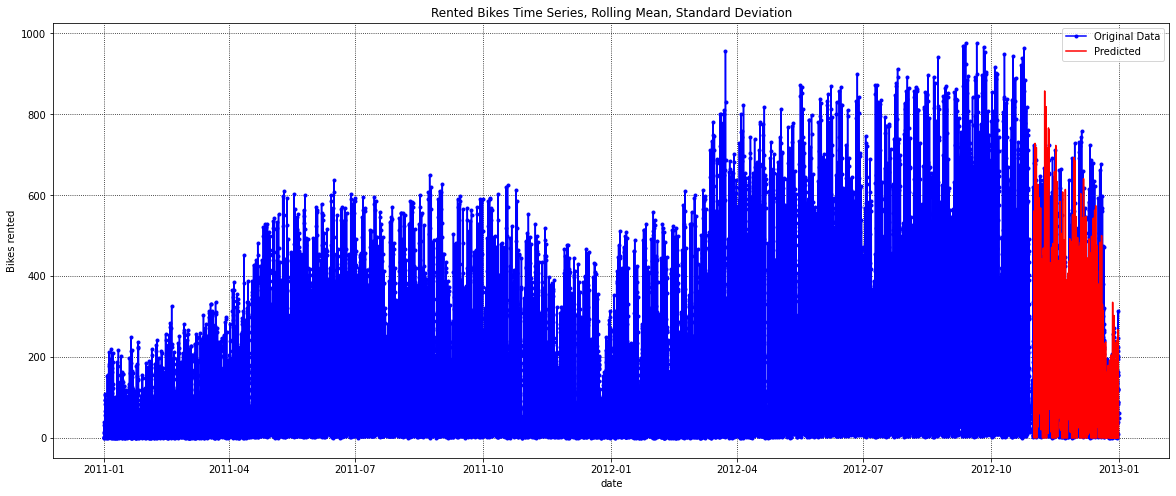

In [ ]:
plt.subplots(1, 1, figsize=(20, 8))
plt.plot(df_unimp, '-ro', markersize=3, color="blue",label="Original Data")
plt.plot(y_pred, color="red", label="Predicted")
#plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in Passenger Number")
plt.grid(linestyle=':', color='k')
plt.xlabel("date")
plt.ylabel("Bikes rented")
plt.title("Rented Bikes Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")
plt.show()

##ARIMA

Next I am going to test special time-series models - ARIMA and SARIMAX.

##Data splitting

In [ ]:
N_test = 1464
print(f"We have {len(df)} points totally and last {N_test} test points amongst them.")

train_ind = np.arange(len(df)-N_test)
test_ind = np.arange(len(df)-N_test, len(df))

train = df.iloc[train_ind, :]
test = df.iloc[test_ind, :]

We have 17544 points totally and last 1464 test points amongst them.


For finding the best values for p, d, and q parameters of the ARIMA model I will look on the autocorrelation and the partial autocorrelation plots.

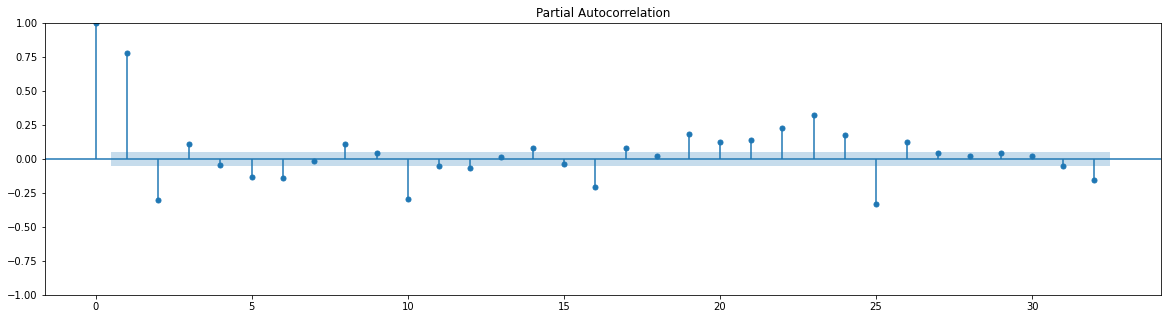

In [ ]:
fig, ax1  = plt.subplots(figsize=(20, 5))
plot_pacf(df.cnt[month_start:two_month_end], ax=ax1)
plt.show()

Partial autocorrelation defines auto-regression (AR) coefficient (p). Here we see again daily autocorrelation, so I will take p=24. I also tried 2 and 3, but results were worse.  

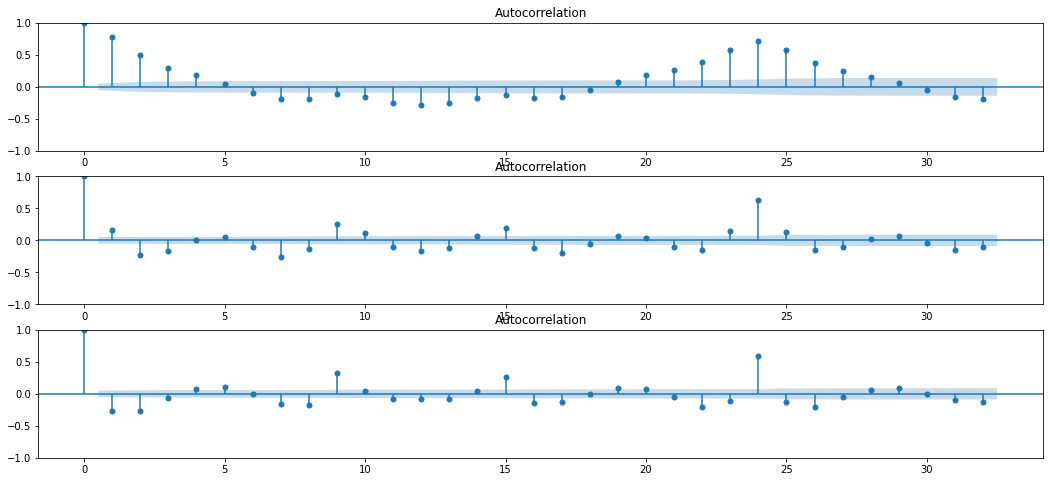

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(df.cnt[month_start:two_month_end], ax=ax1)
plot_acf(df.cnt[month_start:two_month_end].diff().dropna(), ax=ax2)
plot_acf(df.cnt[month_start:two_month_end].diff().diff().dropna(), ax=ax3)
plt.show()

Autocorrelation defines the moving average (MA) coefficient (q), and I will take also 24, as we would like to catch seasonality (at least the daily component) even though ARIMA doesn't really design to do this.

I also take d=1 as this coefficient is a shift value for differentiation which we definitely need to use in order to beat the non-stationarity of our series.

In [ ]:
p, d, q = 24, 1, 24

In [ ]:
arima_model = ARIMA(train, order=(p, d, q)).fit()
print()
print(f"ARIMA model ({p}, {d}, {q}):")
print(arima_model.params)

prediction_arima_train = arima_model.predict(train.index[0], train.index[-1])
prediction_arima_test = arima_model.predict(test_ind[0], test_ind[-1])

mae_arima = mean_absolute_error(y_true=test, y_pred=prediction_arima_test)

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



ARIMA model (24, 1, 24):
ar.L1       -0.104576
ar.L2       -0.178609
ar.L3       -0.139491
ar.L4       -0.115111
ar.L5       -0.134379
ar.L6       -0.117471
ar.L7       -0.109198
ar.L8       -0.164914
ar.L9       -0.097986
ar.L10      -0.174254
ar.L11      -0.155183
ar.L12      -0.162258
ar.L13      -0.186589
ar.L14      -0.149059
ar.L15      -0.128168
ar.L16      -0.155687
ar.L17      -0.091292
ar.L18      -0.159451
ar.L19      -0.109162
ar.L20      -0.112197
ar.L21      -0.152934
ar.L22      -0.121964
ar.L23      -0.123045
ar.L24       0.705680
ma.L1        0.138978
ma.L2       -0.207540
ma.L3       -0.217621
ma.L4       -0.169269
ma.L5       -0.107196
ma.L6       -0.097822
ma.L7       -0.116438
ma.L8       -0.106912
ma.L9        0.158085
ma.L10       0.304692
ma.L11       0.119728
ma.L12       0.022095
ma.L13       0.022030
ma.L14       0.033562
ma.L15      -0.020335
ma.L16      -0.161201
ma.L17      -0.188156
ma.L18      -0.036406
ma.L19      -0.044192
ma.L20      -0.022174
ma.L21

In the summary below, we can see that p-values for the majority of obtained coefficients are less than 0.05 so these coefficients are significant.

In [ ]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    cnt   No. Observations:                16080
Model:               ARIMA(24, 1, 24)   Log Likelihood              -87946.181
Date:                Tue, 14 Mar 2023   AIC                         175990.362
Time:                        13:13:23   BIC                         176366.941
Sample:                    01-01-2011   HQIC                        176114.882
                         - 10-31-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1046      0.025     -4.225      0.000      -0.153      -0.056
ar.L2         -0.1786      0.024     -7.506      0.000      -0.225      -0.132
ar.L3         -0.1395      0.025     -5.676      0.000      -0.188      -0.091
ar.L4         -0.1151      0.027     -4.309      0.000      -0.167      -0.063
ar.L5         -0.1344      0.024     -5.637      0.000      -0.181      -0.088
ar.L6         -0.1175      0.023     -5.046      0.000      -0.163      -0.072
ar.L7         -0.1092      0.024     -4.630      0.000      -0.155      -0.063
ar.L8         -0.1649      0.020     -8.397      0.000      -0.203      -0.126
ar.L9         -0.0980      0.024     -4.138      0.000      -0.144      -0.052
ar.L10        -0.1743      0.022     -8.018      0.000      -0.217      -0.132
ar.L11        -0.1552      0.022     -6.917      0.000      -0.199      -0.111
ar.L12        -0.1623      0.025     -6.514      0.000      -0.211      -0.113
ar.L13        -0.1866      0.023     -8.289      0.000      -0.231      -0.142
ar.L14        -0.1491      0.023     -6.544      0.000      -0.194      -0.104
ar.L15        -0.1282      0.024     -5.411      0.000      -0.175      -0.082
ar.L16        -0.1557      0.021     -7.562      0.000      -0.196      -0.115
ar.L17        -0.0913      0.025     -3.718      0.000      -0.139      -0.043
ar.L18        -0.1595      0.023     -6.807      0.000      -0.205      -0.114
ar.L19        -0.1092      0.025     -4.449      0.000      -0.157      -0.061
ar.L20        -0.1122      0.026     -4.285      0.000      -0.164      -0.061
ar.L21        -0.1529      0.022     -6.999      0.000      -0.196      -0.110
ar.L22        -0.1220      0.021     -5.939      0.000      -0.162      -0.082
ar.L23        -0.1230      0.021     -5.886      0.000      -0.164      -0.082
ar.L24         0.7057      0.018     40.310      0.000       0.671       0.740
ma.L1          0.1390      0.026      5.407      0.000       0.089       0.189
ma.L2         -0.2075      0.025     -8.336      0.000      -0.256      -0.159
ma.L3         -0.2176      0.024     -8.959      0.000      -0.265      -0.170
ma.L4         -0.1693      0.022     -7.635      0.000      -0.213      -0.126
ma.L5         -0.1072      0.023     -4.629      0.000      -0.153      -0.062
ma.L6         -0.0978      0.022     -4.525      0.000      -0.140      -0.055
ma.L7         -0.1164      0.019     -6.059      0.000      -0.154      -0.079
ma.L8         -0.1069      0.021     -5.042      0.000      -0.148      -0.065
ma.L9          0.1581      0.019      8.314      0.000       0.121       0.195
ma.L10         0.3047      0.017     17.514      0.000       0.271       0.339
ma.L11         0.1197      0.019      6.424      0.000       0.083       0.156
ma.L12         0.0221      0.019      1.157      0.247      -0.015       0.060
ma.L13         0.0220      0.019      1.140      0.254      -0.016       0.060
ma.L14         0.0336      0.018      1.861      0.063      -0.002       0.069
ma

Here is how ARIMA's predictions looks on the plot:

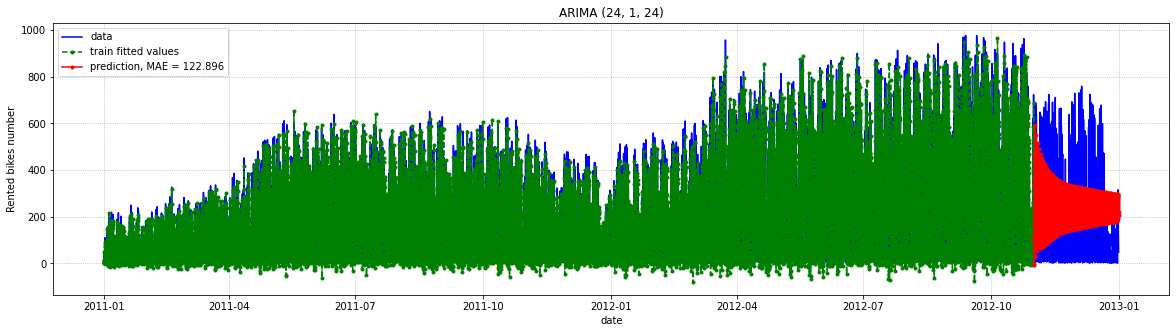

In [ ]:
fig, ax  = plt.subplots(figsize=(20, 5))
plt.plot(df.index, df, '-b', label="data")
plt.plot(arima_model.fittedvalues, '--og', markersize=3,
         label="train fitted values")
plt.plot(test.index, prediction_arima_test, '-or', markersize=3,
         label=f"prediction, MAE = {mae_arima:0.3f}")
plt.grid(linestyle=':')
plt.legend()
plt.xlabel("date")
plt.ylabel("Rented bikes number")
plt.title(f"ARIMA {(p, d, q)}")
plt.show(True)

With ARIMA I got MAE=122.90 which is not so good. On the plot, we also can see that it definitely did not catch the trend.  

Rolling Forecast Origin:

In [ ]:
rolling_predictions = test.copy()
for train_end in test.index:
	train_data = df[:train_end-timedelta(days=1)]
	model = ARIMA(train, order=(p, d, q))
	model_fit = model.fit()
	pred = model_fit.forecast()
	rolling_predictions[train_end] = pred
rolling_residuals = test - rolling_predictions

To improve ARIMA's result I might use the rolling forecast origin method, which consequentially predicts values one time-unit (an hour in our case) forward each time. Unfortunately, I lack time to do it now,  but I am going to do it later.

## SARIMAX model

I also tried to train the SARIMAX model with different coefficients. The results are below. I actually failed to beat the results of the Linear Regression with seasonality components. MAE=128.44 is even worse than ARIMA shown. Again, unfortunately, I have no time to improve this model so I mark this as TBD. Later I will back to this task.  

In [ ]:
order = (0, 1, 0)
seasonal_order = (1, 0, 2, 24)

sarima_model = SARIMAX(train, order=order, seasonal_order=seasonal_order).fit()
print(sarima_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                     cnt   No. Observations:                16080
Model:             SARIMAX(0, 1, 0)x(1, 0, [1, 2], 24)   Log Likelihood              -89186.854
Date:                                 Tue, 14 Mar 2023   AIC                         178381.709
Time:                                         20:27:08   BIC                         178412.450
Sample:                                     01-01-2011   HQIC                        178391.873
                                          - 10-31-2012                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.9996      0.000   5747.144      0.000       0.999       1

In [ ]:
prediction_sarima_train = sarima_model.predict(train.index[0], train.index[-1])
prediction_sarima_test = sarima_model.predict(test_ind[0], test_ind[-1])

mae_sarima = mean_absolute_error(y_true=test, y_pred=prediction_sarima_test)
mae_sarima

128.44349247709684

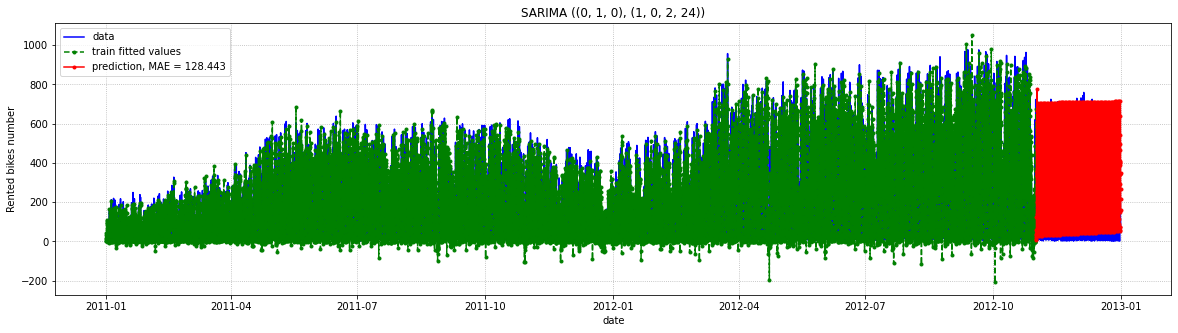

In [ ]:
fig, ax  = plt.subplots(figsize=(20, 5))
plt.plot(df.index, df, '-b', label="data")
plt.plot(sarima_model.fittedvalues, '--og', markersize=3,
         label="train fitted values")
plt.plot(test.index, prediction_sarima_test, '-or', markersize=3,
         label=f"prediction, MAE = {mae_sarima:0.3f}")
plt.grid(linestyle=':')
plt.legend()
plt.xlabel("date")
plt.ylabel("Rented bikes number")
plt.title(f"SARIMA {order, seasonal_order}")
plt.show(True)

##Conclusions:

During the fulfillment of this work, I learned how to deal with time series. I got the notions of stationarity, seasonality, autocorrelation (and partial autocorrelation), and others. I learned how to decompose time series into its components - trends, seasonalities, and residuals. I also learned the basics of residuals analysis.

The prediction models I used are:
*   Linear Regression with additional seasonal components extracted from the time series.
*   ARIMA
*   SARIMAX

The best result I got with the Linear Regression model improved with the seasonal components. MAE = 74.36 which is even better than the result of the CatBoost Regressor obtained in previous homework in the case when we train on the first half of the data and tried to predict the second half (MAE=90.45).